# LIGTH-GBM COVARIATES CQR MODELS
This notebook contains the code for the Conformal Quantile Regression (CQR) calibration and evaluation of the two ligthGBM models previously trained with covariates using the Darts library.

Both versions of the model are evaluated on their respective test sets, with the MinMax-scaled model also evaluated on a dedicated test set.

In [1]:
# We install darts
!pip install u8darts[torch] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Necessary imports to read the datasets
import pandas as pd
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
from darts import TimeSeries
from darts.models import LightGBMModel
from darts.dataprocessing.transformers import Scaler
from darts import concatenate, metrics
from darts.models import ConformalQRModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# We start with the minmax scaling

In [5]:
# Load model
model = LightGBMModel.load("/content/drive/MyDrive/Colab Notebooks/TFG/data/02_models/lightGBM/covariates/lightgbm_model_covariates.pkl")

In [6]:
# Load the test data
test_data = joblib.load('/content/drive/MyDrive/Colab Notebooks/TFG/data/01_datasets/train_test/scaled_test.pkl')

# Extract components
scaled_val_series = test_data['validation']        # validation not used in our case
scaled_calib_test_series = test_data['calib_test']
scalers_test = test_data['scalers']           # the scalers to reescale the series later

# Reuse the same sorted meter IDs to align
meter_ids_test = sorted(scaled_calib_test_series.keys())

# Build aligned lists
test_series_scaled = [scaled_calib_test_series[meter_id] for meter_id in meter_ids_test]

print(f"Loaded {len(test_series_scaled)} time series for testing.")

Loaded 60 time series for testing.


In [7]:
# We define the list of holidays in Catalonia during 2022 and 2023
holiday_dates = pd.to_datetime([
    # 2022
    "2022-01-01", "2022-01-06", "2022-04-15", "2022-04-18", "2022-05-01", "2022-06-06",
    "2022-06-24", "2022-08-15", "2022-09-11", "2022-09-24", "2022-10-12", "2022-11-01",
    "2022-12-06", "2022-12-08", "2022-12-25", "2022-12-26",
    # 2023
    "2023-01-01", "2023-01-06", "2023-04-07", "2023-04-10", "2023-05-01", "2023-05-29",
    "2023-06-24", "2023-08-15", "2023-09-11", "2023-09-24", "2023-10-12", "2023-11-01",
    "2023-12-06", "2023-12-08", "2023-12-25", "2023-12-26"
])

# We define the complete date range for our dataset
date_range = pd.date_range(start='2022-01-01', end='2023-12-31')

# We create a binary holiday series where 1 indicates a holiday and 0 otherwise
holiday_series = pd.Series(0, index=date_range)
holiday_series.loc[holiday_dates.intersection(date_range)] = 1
holiday_timeseries = TimeSeries.from_series(holiday_series.rename("is_holiday"))

# We create a binary series indicating whether each date is a weekend (Saturday or Sunday)
is_weekend_series = pd.Series((date_range.weekday >= 5).astype(int), index=date_range)
is_weekend_timeseries = TimeSeries.from_series(is_weekend_series.rename("is_weekend"))

# We create a normalized day-of-year series (scaled to [0, 1])
day_of_year_norm = pd.Series(date_range.dayofyear / 365, index=date_range)
day_of_year_timeseries = TimeSeries.from_series(day_of_year_norm.rename("day_of_year_norm"))

# We build the future covariates for the test set
future_covariates_test = []

for test_ts in test_series_scaled:
    test_cov = concatenate([
        datetime_attribute_timeseries(test_ts, "day_of_week", one_hot=True),
        datetime_attribute_timeseries(test_ts, "month", one_hot=True),
        is_weekend_timeseries.slice_intersect(test_ts),
        holiday_timeseries.slice_intersect(test_ts),
        day_of_year_timeseries.slice_intersect(test_ts)
    ], axis=1)

    future_covariates_test.append(test_cov)

In [ ]:
# Constants
start_date = pd.Timestamp("2023-11-6")
horizon = 7
quantiles = [0.05, 0.5, 0.95]
pred_kwargs={"predict_likelihood_parameters": True, "verbose": True}

# Initialize the conformal quantile regression model
cp_model = ConformalQRModel(
    model=model,
    quantiles=quantiles,
    symmetric=False
    # if cal_length is None, it considers all calibration scores
)
q_interval = cp_model.q_interval  # [(0.05, 0.95)]
q_range = cp_model.interval_range  # [0.9]

# Prepare to collect results
all_hfcs = {}
all_bt_results = {}

# We loop over each time series
for meter_id, ts, fcov in zip(meter_ids_test, test_series_scaled, future_covariates_test):
    # Historical forecasts
    hfcs = cp_model.historical_forecasts(
        series=ts,
        future_covariates=fcov,
        forecast_horizon=7,
        start=start_date,
        last_points_only=False,
        stride=7,
        **pred_kwargs,
    )

    scaler = scalers_test[meter_id]
    widths = []

    for forecast in hfcs:
        q05 = forecast["Consumption per meter_q0.05"]
        q95 = forecast["Consumption per meter_q0.95"]
        q05_orig = scaler.inverse_transform(q05)
        q95_orig = scaler.inverse_transform(q95)
        width = (q95_orig - q05_orig).values()
        widths.append(width)

    mean_width = np.mean([np.mean(w) for w in widths])

    # We evaluate the already-generated historical forecasts
    bt = cp_model.backtest(
        ts,
        future_covariates=fcov,
        historical_forecasts=hfcs,
        last_points_only=False,
        metric=[metrics.mic, metrics.miw],
        metric_kwargs={"q_interval": q_interval},
    )
    df_results = pd.DataFrame({"Interval": q_range, "Coverage": bt[0], "Width": bt[1], "Width rescaled": mean_width})
    print(f"Results for meter {meter_id}:\n", df_results, "\n")

    # Store results
    all_hfcs[meter_id] = hfcs
    all_bt_results[meter_id] = df_results

# We combine results across meters
combined_results = pd.concat(all_bt_results.values(), keys=all_bt_results.keys())
combined_results.reset_index(level=1, drop=True, inplace=True)


conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 297.78it/s]


Results for meter 0801501002_Badalona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.223573       21.961559 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 418.86it/s]


Results for meter 0801503008_Badalona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.308984       29.359707 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 428.38it/s]


Results for meter 0801901042_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9       1.0  0.746103       11.609366 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 357.85it/s]


Results for meter 0801902035_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  0.154039        1.877732 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 402.98it/s]


Results for meter 0801902037_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.191997        3.223625 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 448.70it/s]


Results for meter 0801902052_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9      0.75  0.305636        3.459795 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 428.43it/s]


Results for meter 0801902102_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.235755        3.159115 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 299.99it/s]


Results for meter 0801903006_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.329133        3.390065 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 397.60it/s]


Results for meter 0801903035_Barcelona:
    Interval  Coverage   Width  Width rescaled
0       0.9  0.928571  0.2873        0.804439 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 440.68it/s]


Results for meter 0801903040_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.821429  0.385386        1.048249 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 428.17it/s]


Results for meter 0801903048_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.821429  0.188787        4.383641 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 341.93it/s]


Results for meter 0801903060_Barcelona:
    Interval  Coverage   Width  Width rescaled
0       0.9  0.982143  0.3681        4.619656 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 275.68it/s]


Results for meter 0801903067_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  0.285551        0.993716 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 464.78it/s]


Results for meter 0801903081_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.270867        2.343003 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 458.81it/s]


Results for meter 0801904008_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.204805        8.454334 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 321.09it/s]


Results for meter 0801904030_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.255375        3.276464 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 255.36it/s]


Results for meter 0801905054_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.173654        17.68668 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 427.02it/s]


Results for meter 0801905091_Barcelona:
    Interval  Coverage    Width  Width rescaled
0       0.9  0.964286  0.29691         6.26778 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 407.13it/s]


Results for meter 0801906002_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.367432        3.012946 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 440.09it/s]


Results for meter 0801906010_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  0.273595        7.480081 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 462.97it/s]


Results for meter 0801906041_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  0.227676        6.279316 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 442.55it/s]


Results for meter 0801907003_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  0.080573        1.608241 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 287.92it/s]


Results for meter 0801907011_Barcelona:
    Interval  Coverage    Width  Width rescaled
0       0.9  0.946429  0.28915         3.08812 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 449.24it/s]


Results for meter 0801907013_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.250263        2.227338 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 468.82it/s]


Results for meter 0801907025_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9       1.0  0.425796        11.83287 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 429.43it/s]


Results for meter 0801907037_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  0.314373        5.539255 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 270.91it/s]


Results for meter 0801907084_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.475121       12.220117 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 430.12it/s]


Results for meter 0801907088_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.206896        13.41102 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 444.23it/s]


Results for meter 0801907115_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.189744       14.096098 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 339.52it/s]


Results for meter 0801908002_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  0.203482        4.106274 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 474.99it/s]


Results for meter 0801908022_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.242462        3.622383 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 452.14it/s]


Results for meter 0801908043_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  0.202431        0.827941 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 453.10it/s]


Results for meter 0801908046_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.320945        2.506579 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 302.95it/s]


Results for meter 0801908049_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.296791       16.136504 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 401.23it/s]


Results for meter 0801908061_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.315571        1.464251 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 427.29it/s]


Results for meter 0801908088_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.273882        6.233565 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 455.31it/s]


Results for meter 0801908111_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.732143  0.330627        8.473982 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 369.37it/s]


Results for meter 0801909015_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  0.192498        5.224389 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 405.35it/s]


Results for meter 0801909017_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9       1.0  0.230997        8.706294 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 453.31it/s]


Results for meter 0801910053_Barcelona:
    Interval  Coverage    Width  Width rescaled
0       0.9  0.982143  0.54427        9.345116 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 315.18it/s]


Results for meter 0801910054_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.549276        5.822322 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 398.27it/s]


Results for meter 0801910080_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  0.319917        1.487615 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 400.50it/s]


Results for meter 0801910092_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.471379        1.781811 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 467.16it/s]


Results for meter 0801910119_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.282853        1.236069 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 419.20it/s]


Results for meter 0801910235_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.258365        0.713089 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 446.67it/s]


Results for meter 0810101040_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9       1.0  0.396707        7.934135 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 452.29it/s]


Results for meter 0810101041_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.171122        3.680839 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 268.78it/s]


Results for meter 0810102007_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9      0.75  0.551543         7.73815 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 457.13it/s]


Results for meter 0810102008_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.180465        2.277462 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 437.72it/s]


Results for meter 0810102017_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.381291        5.616422 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 434.00it/s]


Results for meter 0810102033_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.821429  0.644686       20.204453 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 395.64it/s]


Results for meter 0810102045_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.456497       11.311995 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 440.58it/s]


Results for meter 0810102048_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  0.140613        3.405639 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 428.79it/s]


Results for meter 0810104040_Hospitalet:
    Interval  Coverage  Width  Width rescaled
0       0.9  0.910714  0.369        1.656809 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 309.19it/s]


Results for meter 0810105003_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.133226         0.81268 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 456.62it/s]


Results for meter 0810105026_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.660714  0.144864        4.111231 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 438.35it/s]


Results for meter 0810105032_Hospitalet:
    Interval  Coverage   Width  Width rescaled
0       0.9  0.910714  0.1937        4.280759 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 435.84it/s]


Results for meter 0810106012_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  0.175155         1.54662 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 282.59it/s]


Results for meter 0810106013_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9       1.0  0.388818        2.535092 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 417.28it/s]

Results for meter 0810106023_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.304789         1.82264 



In [ ]:
mean_coverage = combined_results["Coverage"].mean()
mean_width = combined_results["Width"].mean()
mean_width_rescaled = combined_results["Width rescaled"].mean()

print(f"Mean Coverage: {mean_coverage:.4f}")
print(f"Mean Width: {mean_width:.4f}")
print(f"Mean Width rescaled: {mean_width_rescaled:.4f}")

Mean Coverage: 0.9089
Mean Width: 0.2997
Mean Width rescaled: 6.0890


In [ ]:
for meter_id, hfcs in all_hfcs.items():
    # Get the actual time series
    ts = scaled_calib_test_series[meter_id]

    # Get scaler and results
    scaler = scalers_test[meter_id]
    df_result = all_bt_results[meter_id]
    coverage = df_result["Coverage"].iloc[0]
    width = df_result["Width rescaled"].iloc[0]

    # Start a new plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot actuals (rescaled)
    ts_orig = scaler.inverse_transform(ts)
    ts_orig.plot(ax=ax, label='Actual (rescaled)', lw=2)

    full_lower = []
    full_upper = []

    # Collect lower and upper quantiles from each forecast window
    for forecast in hfcs:
        if ('Consumption per meter_q0.05' in forecast.components
            and 'Consumption per meter_q0.95' in forecast.components):

            lower = forecast['Consumption per meter_q0.05']
            upper = forecast['Consumption per meter_q0.95']
            lower_orig = scaler.inverse_transform(lower)
            upper_orig = scaler.inverse_transform(upper)
            full_lower.append(lower_orig)
            full_upper.append(upper_orig)


    if full_lower and full_upper:
        # Concatenate all the TimeSeries pieces into full series
        combined_lower = concatenate(full_lower)
        combined_upper = concatenate(full_upper)

        # Plot the quantile area as a filled region
        ax.fill_between(
            combined_lower.time_index,
            combined_lower.values().flatten(),
            combined_upper.values().flatten(),
            color='orange',
            alpha=0.3,
            label='0.05-0.95 quantile'
        )

    ax.set_title(f"Meter {meter_id} - Forecasts vs Actuals")
    ax.legend()
    plt.show()

    # Print the metrics below each plot
    print(f"Meter {meter_id} - Coverage: {coverage:.4f}, Width: {width:.4f}\n")


Output hidden; open in https://colab.research.google.com to view.

In [8]:
# We start with the standard scaling

In [9]:
# Load model
model = LightGBMModel.load("/content/drive/MyDrive/Colab Notebooks/TFG/data/02_models/lightGBM/covariates/lightgbm_model_standard_covariates.pkl")

In [10]:
# Load the test data
test_data = joblib.load('/content/drive/MyDrive/Colab Notebooks/TFG/data/01_datasets/train_test/scaled_test_standard.pkl')

# Extract components
scaled_val_series = test_data['validation']        # validation not used in our case
scaled_calib_test_series = test_data['calib_test']
scalers_test = test_data['scalers']           # the scalers to reescale the series later

# Reuse the same sorted meter IDs to align
meter_ids_test = sorted(scaled_calib_test_series.keys())

# Build aligned lists
test_series_scaled = [scaled_calib_test_series[meter_id] for meter_id in meter_ids_test]

print(f"Loaded {len(test_series_scaled)} time series for testing.")

Loaded 60 time series for testing.


In [11]:
# We build the future covariates for the test set
future_covariates_test = []

for test_ts in test_series_scaled:
    test_cov = concatenate([
        datetime_attribute_timeseries(test_ts, "day_of_week", one_hot=True),
        datetime_attribute_timeseries(test_ts, "month", one_hot=True),
        is_weekend_timeseries.slice_intersect(test_ts),
        holiday_timeseries.slice_intersect(test_ts),
        day_of_year_timeseries.slice_intersect(test_ts)
    ], axis=1)

    future_covariates_test.append(test_cov)

In [12]:
# Constants
start_date = pd.Timestamp("2023-11-6")
horizon = 7
quantiles = [0.05, 0.5, 0.95]
pred_kwargs={"predict_likelihood_parameters": True, "verbose": True}

# Initialize the conformal quantile regression model
cp_model = ConformalQRModel(
    model=model,
    quantiles=quantiles,
    symmetric=False
    # if cal_length is None, it considers all calibration scores
)
q_interval = cp_model.q_interval  # [(0.05, 0.95)]
q_range = cp_model.interval_range  # [0.9]

# Prepare to collect results
all_hfcs = {}
all_bt_results = {}

# We loop over each time series
for meter_id, ts, fcov in zip(meter_ids_test, test_series_scaled, future_covariates_test):
    # Historical forecasts
    hfcs = cp_model.historical_forecasts(
        series=ts,
        future_covariates=fcov,
        forecast_horizon=7,
        start=start_date,
        last_points_only=False,
        stride=7,
        **pred_kwargs,
    )

    scaler = scalers_test[meter_id]
    widths = []

    for forecast in hfcs:
        q05 = forecast["Consumption per meter_q0.05"]
        q95 = forecast["Consumption per meter_q0.95"]
        q05_orig = scaler.inverse_transform(q05)
        q95_orig = scaler.inverse_transform(q95)
        width = (q95_orig - q05_orig).values()
        widths.append(width)

    mean_width = np.mean([np.mean(w) for w in widths])

    # We evaluate the already-generated historical forecasts
    bt = cp_model.backtest(
        ts,
        future_covariates=fcov,
        historical_forecasts=hfcs,
        last_points_only=False,
        metric=[metrics.mic, metrics.miw],
        metric_kwargs={"q_interval": q_interval},
    )
    df_results = pd.DataFrame({"Interval": q_range, "Coverage": bt[0], "Width": bt[1], "Width rescaled": mean_width})
    print(f"Results for meter {meter_id}:\n", df_results, "\n")

    # Store results
    all_hfcs[meter_id] = hfcs
    all_bt_results[meter_id] = df_results

# We combine results across meters
combined_results = pd.concat(all_bt_results.values(), keys=all_bt_results.keys())
combined_results.reset_index(level=1, drop=True, inplace=True)

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 418.15it/s]


Results for meter 0801501002_Badalona:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  1.583713       18.699324 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 320.99it/s]


Results for meter 0801503008_Badalona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  1.777294       28.907348 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 457.96it/s]


Results for meter 0801901042_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9       1.0  5.625324       11.921515 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 445.25it/s]


Results for meter 0801902035_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  1.157238        2.275948 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 453.71it/s]


Results for meter 0801902037_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  1.352647        3.220391 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 338.26it/s]


Results for meter 0801902052_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.732143  2.364095         4.08426 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 412.65it/s]


Results for meter 0801902102_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  1.488545        3.182327 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 428.32it/s]


Results for meter 0801903006_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  2.079652        3.299882 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 432.25it/s]


Results for meter 0801903035_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  2.018954        0.919201 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 315.56it/s]


Results for meter 0801903040_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  2.541981         1.11278 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 428.66it/s]


Results for meter 0801903048_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  2.558174        4.664819 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 461.60it/s]


Results for meter 0801903060_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  2.136089        4.242038 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 442.02it/s]


Results for meter 0801903067_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  1.671914        1.067634 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 281.55it/s]


Results for meter 0801903081_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  1.910731        2.609266 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 436.54it/s]


Results for meter 0801904008_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  1.781066        8.758426 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 475.38it/s]


Results for meter 0801904030_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  1.734755        3.556032 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 469.03it/s]


Results for meter 0801905054_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.914272       16.526079 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 334.49it/s]


Results for meter 0801905091_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  1.712989        6.886357 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 449.70it/s]


Results for meter 0801906002_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  2.191631        3.257689 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 458.42it/s]


Results for meter 0801906010_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  1.881658        7.208115 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 470.40it/s]


Results for meter 0801906041_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  1.458741        6.277578 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 270.64it/s]


Results for meter 0801907003_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.929185        1.974889 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 474.48it/s]


Results for meter 0801907011_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  2.040284        3.352399 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 442.02it/s]


Results for meter 0801907013_Barcelona:
    Interval  Coverage    Width  Width rescaled
0       0.9       1.0  1.51823        2.238817 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 452.30it/s]


Results for meter 0801907025_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  2.523081       10.584987 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 280.56it/s]


Results for meter 0801907037_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  2.012201        5.206811 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 427.99it/s]


Results for meter 0801907084_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  3.988563       13.647595 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 419.16it/s]


Results for meter 0801907088_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  1.118778         8.38053 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 363.74it/s]


Results for meter 0801907115_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  1.048817        15.54771 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 320.48it/s]


Results for meter 0801908002_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  1.470369        3.449765 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 440.86it/s]


Results for meter 0801908022_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.785714  1.494456        2.564231 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 464.38it/s]


Results for meter 0801908043_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  1.620258         0.73028 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 405.42it/s]


Results for meter 0801908046_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  2.225673        2.637069 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 317.56it/s]


Results for meter 0801908049_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  1.445595       13.813832 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 426.25it/s]


Results for meter 0801908061_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  1.760814        1.343045 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 459.42it/s]


Results for meter 0801908088_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  1.699629        6.393092 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 423.07it/s]


Results for meter 0801908111_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9      0.75  2.209705        8.369289 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 458.58it/s]


Results for meter 0801909015_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  1.281096        5.895538 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 447.14it/s]


Results for meter 0801909017_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  1.469941        8.443973 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 457.70it/s]


Results for meter 0801910053_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  3.686401       10.840522 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 424.83it/s]


Results for meter 0801910054_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  2.238851        4.768828 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 404.33it/s]


Results for meter 0801910080_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.803571  2.287902        1.491352 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 432.59it/s]


Results for meter 0801910092_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  2.417801        1.467752 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 464.42it/s]


Results for meter 0801910119_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.990321        0.998997 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 442.40it/s]


Results for meter 0801910235_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  1.482581         0.75052 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 462.18it/s]


Results for meter 0810101040_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  1.988825        7.822866 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 474.06it/s]


Results for meter 0810101041_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9       1.0  1.696299        3.682745 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 407.06it/s]


Results for meter 0810102007_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.767857  4.126315         9.28621 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 447.49it/s]


Results for meter 0810102008_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  1.693609         2.34829 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 474.20it/s]


Results for meter 0810102017_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  1.805974        5.127265 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 418.86it/s]


Results for meter 0810102033_Hospitalet:
    Interval  Coverage    Width  Width rescaled
0       0.9  0.678571  2.85239       16.872032 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 457.05it/s]


Results for meter 0810102045_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  2.330462        10.52205 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 339.83it/s]


Results for meter 0810102048_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  1.942887         3.19832 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 448.56it/s]


Results for meter 0810104040_Hospitalet:
    Interval  Coverage    Width  Width rescaled
0       0.9     0.875  2.58333        1.556814 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 469.99it/s]


Results for meter 0810105003_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  1.093603        0.689359 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 386.88it/s]


Results for meter 0810105026_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  1.944069        4.696458 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 318.97it/s]


Results for meter 0810105032_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  1.479444        4.002656 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 443.98it/s]


Results for meter 0810106012_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  1.251985        1.588052 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 312.32it/s]


Results for meter 0810106013_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9       1.0  2.374973        2.705225 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 454.17it/s]

Results for meter 0810106023_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  1.980641        1.882056 



In [13]:
mean_coverage = combined_results["Coverage"].mean()
mean_width = combined_results["Width"].mean()
mean_width_rescaled = combined_results["Width rescaled"].mean()

print(f"Mean Coverage: {mean_coverage:.4f}")
print(f"Mean Width: {mean_width:.4f}")
print(f"Mean Width rescaled: {mean_width_rescaled:.4f}")

Mean Coverage: 0.9048
Mean Width: 1.9674
Mean Width rescaled: 5.8925


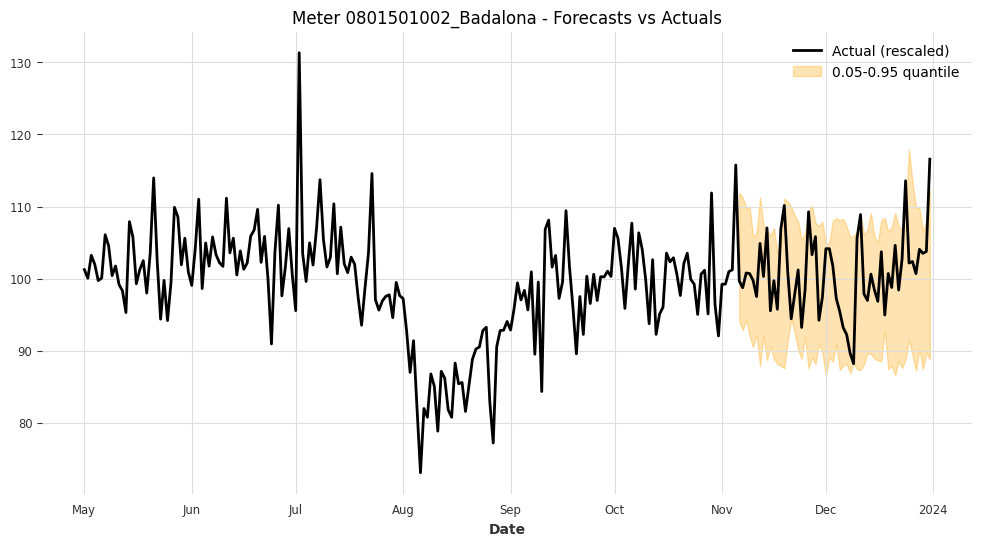

Meter 0801501002_Badalona - Coverage: 0.8750, Width: 18.6993



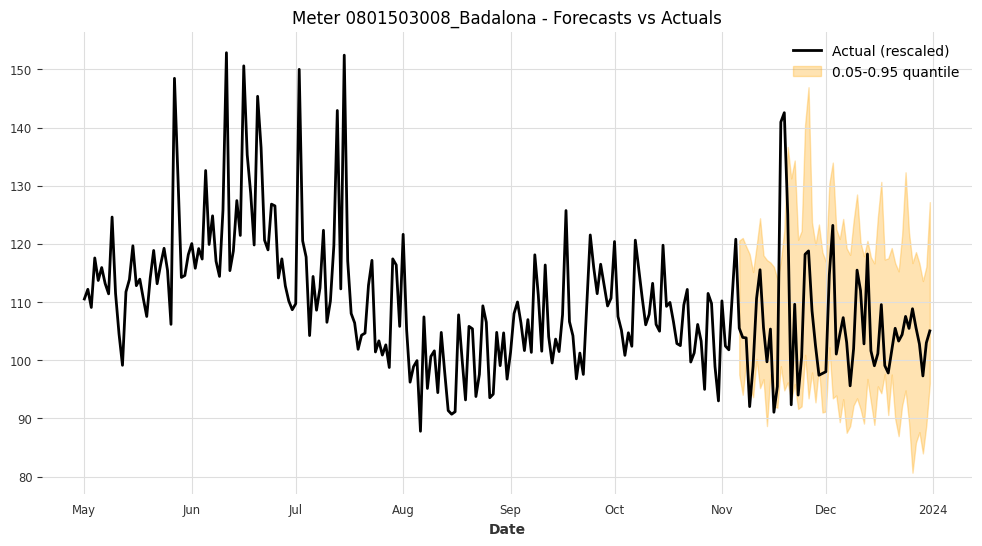

Meter 0801503008_Badalona - Coverage: 0.8929, Width: 28.9073



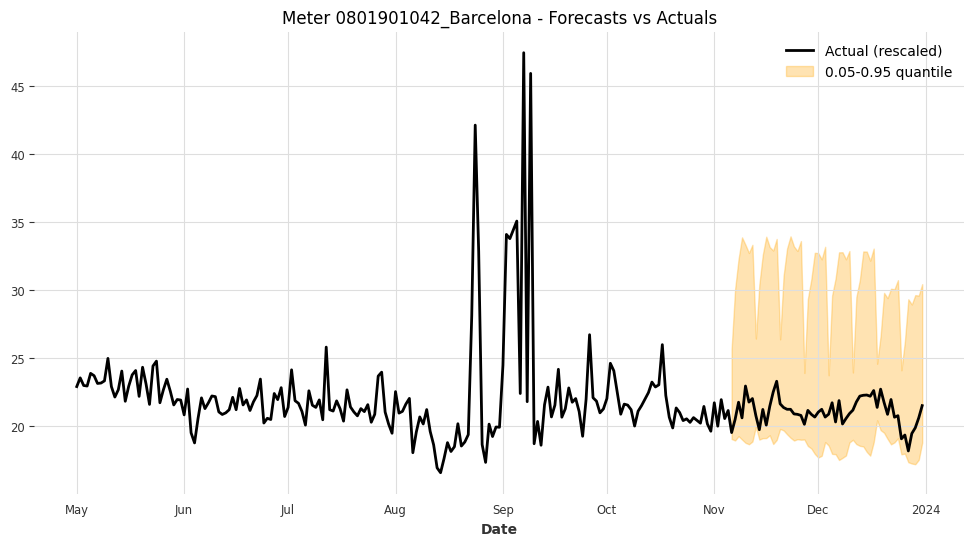

Meter 0801901042_Barcelona - Coverage: 1.0000, Width: 11.9215



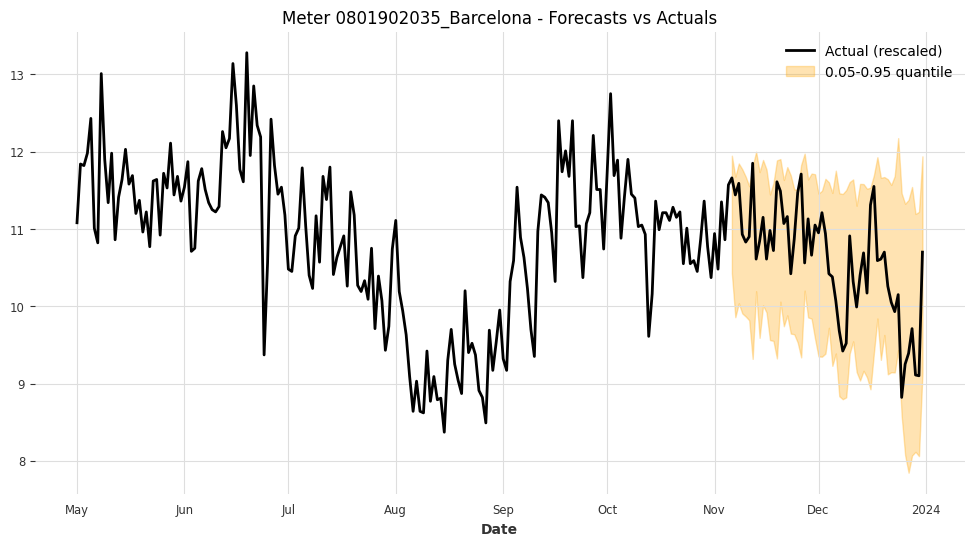

Meter 0801902035_Barcelona - Coverage: 0.9821, Width: 2.2759



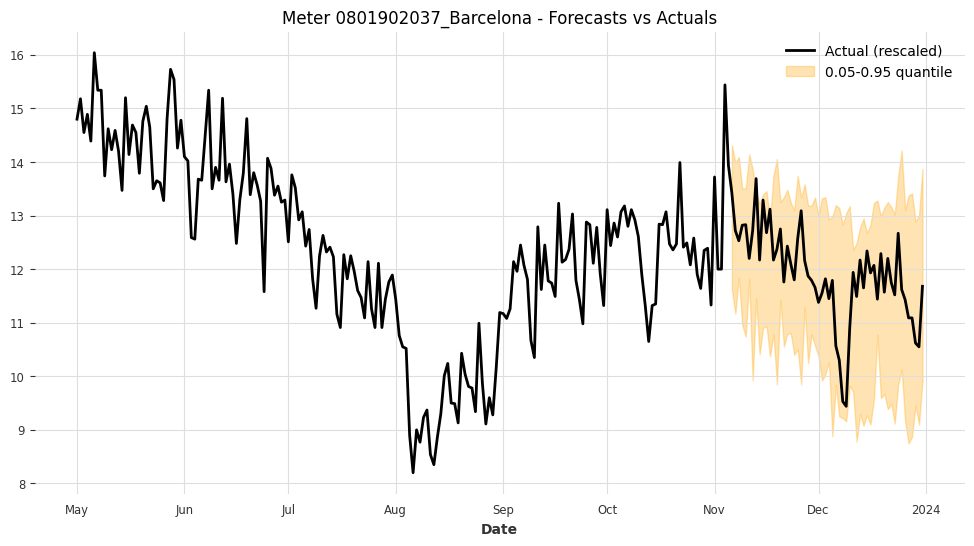

Meter 0801902037_Barcelona - Coverage: 0.9643, Width: 3.2204



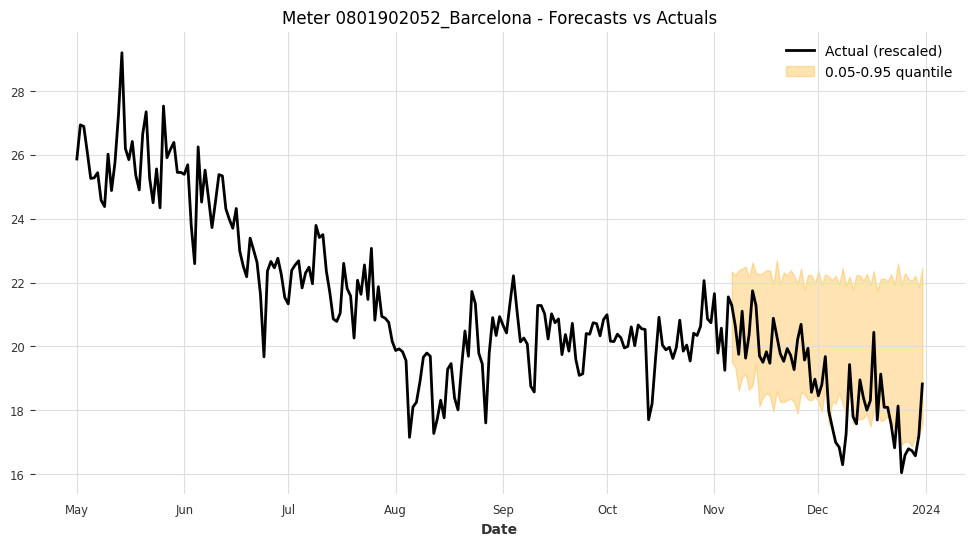

Meter 0801902052_Barcelona - Coverage: 0.7321, Width: 4.0843



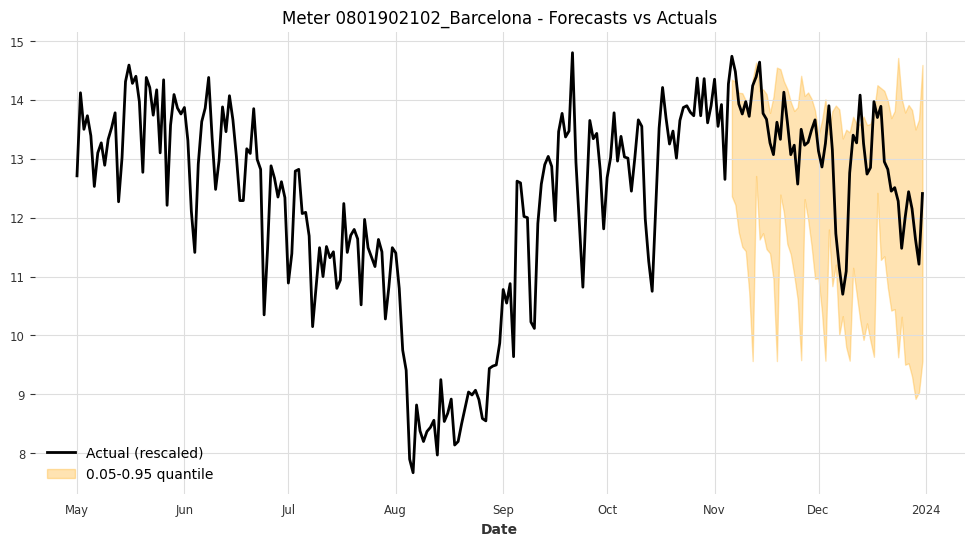

Meter 0801902102_Barcelona - Coverage: 0.8929, Width: 3.1823



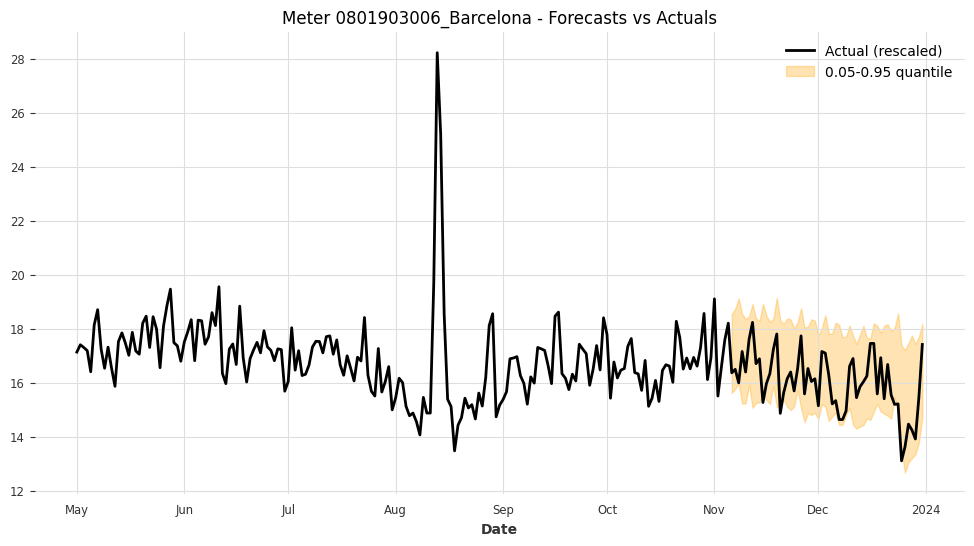

Meter 0801903006_Barcelona - Coverage: 0.9286, Width: 3.2999



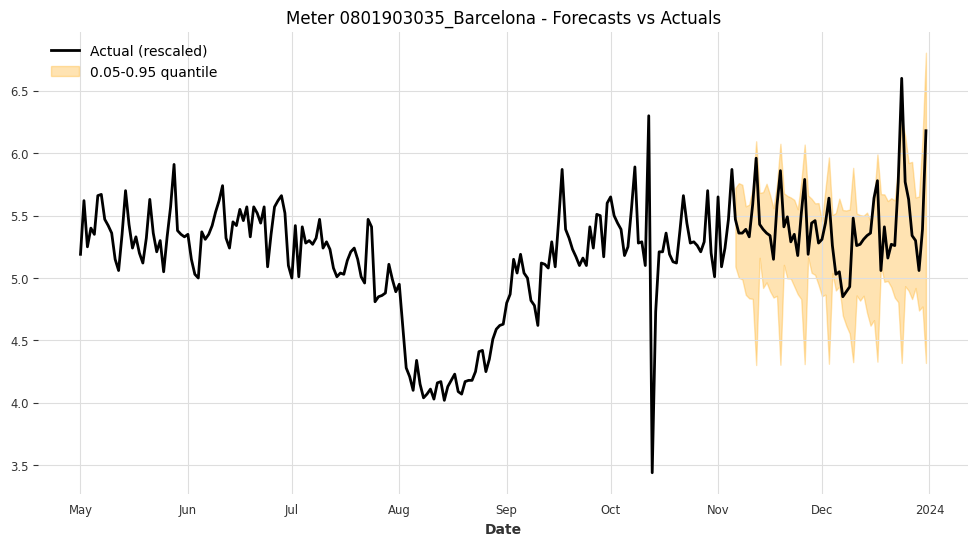

Meter 0801903035_Barcelona - Coverage: 0.9464, Width: 0.9192



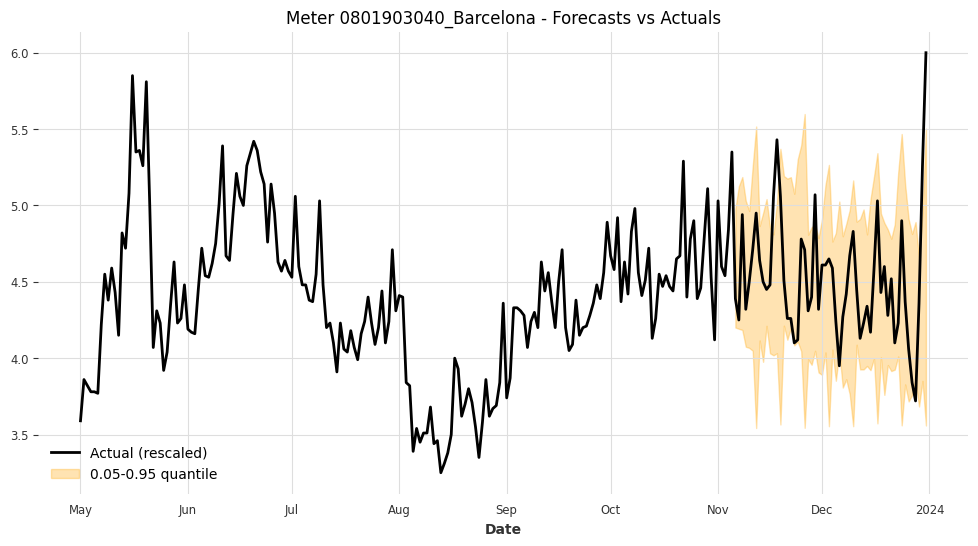

Meter 0801903040_Barcelona - Coverage: 0.8750, Width: 1.1128



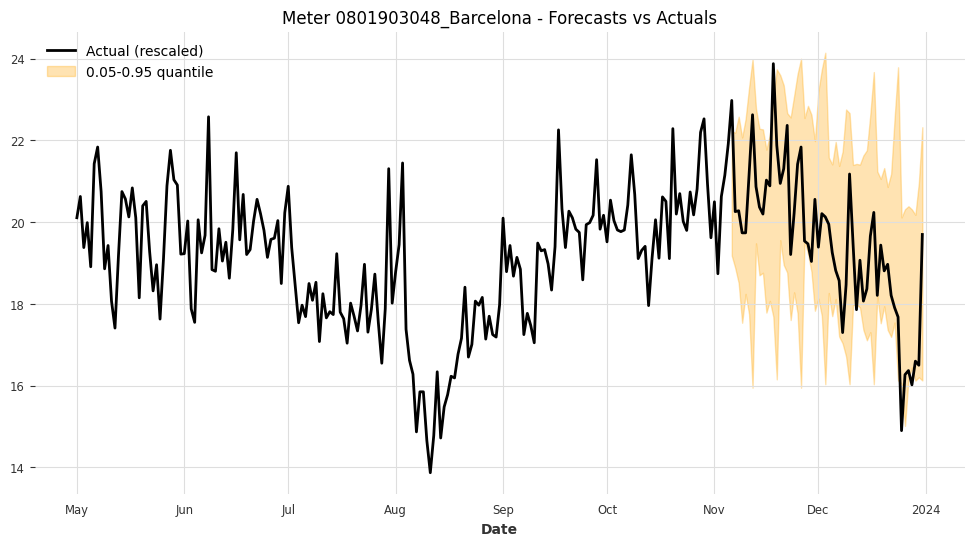

Meter 0801903048_Barcelona - Coverage: 0.8929, Width: 4.6648



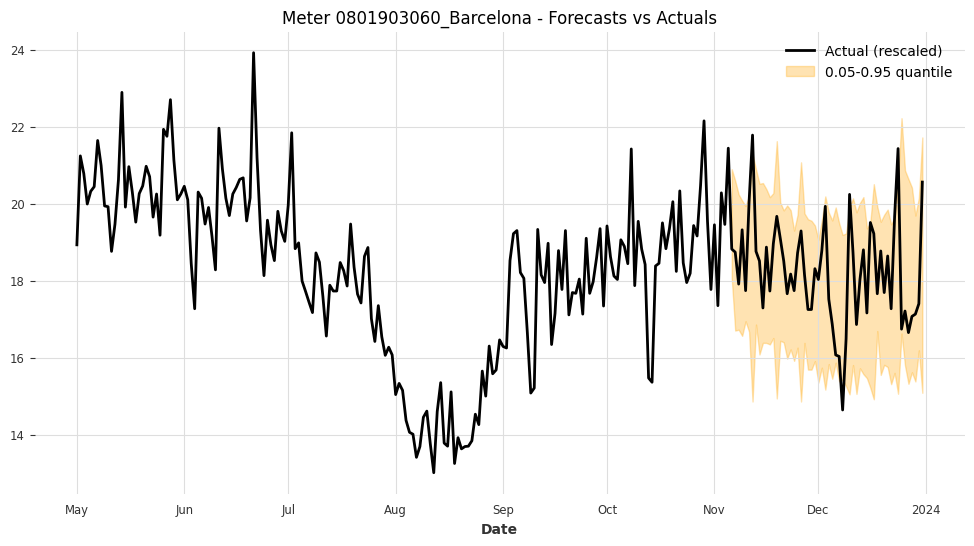

Meter 0801903060_Barcelona - Coverage: 0.9107, Width: 4.2420



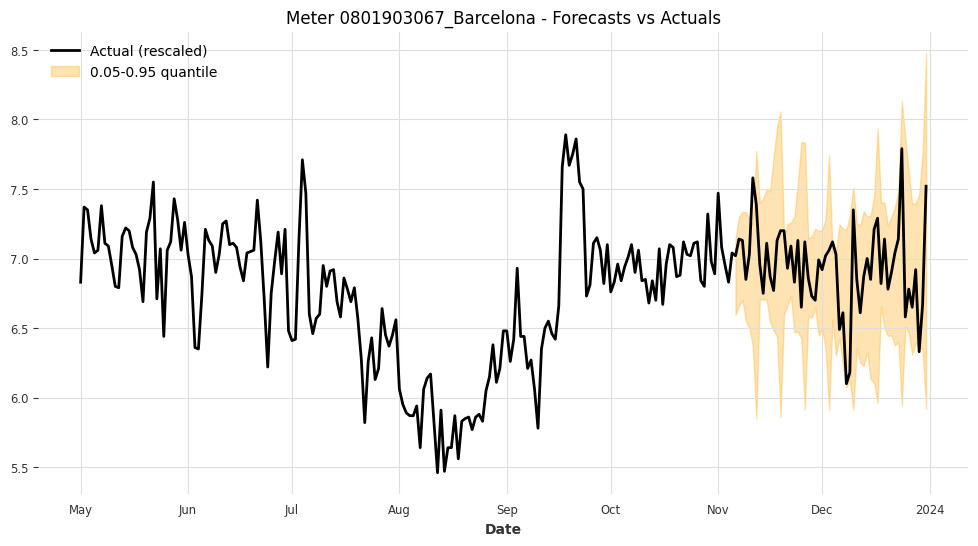

Meter 0801903067_Barcelona - Coverage: 0.9286, Width: 1.0676



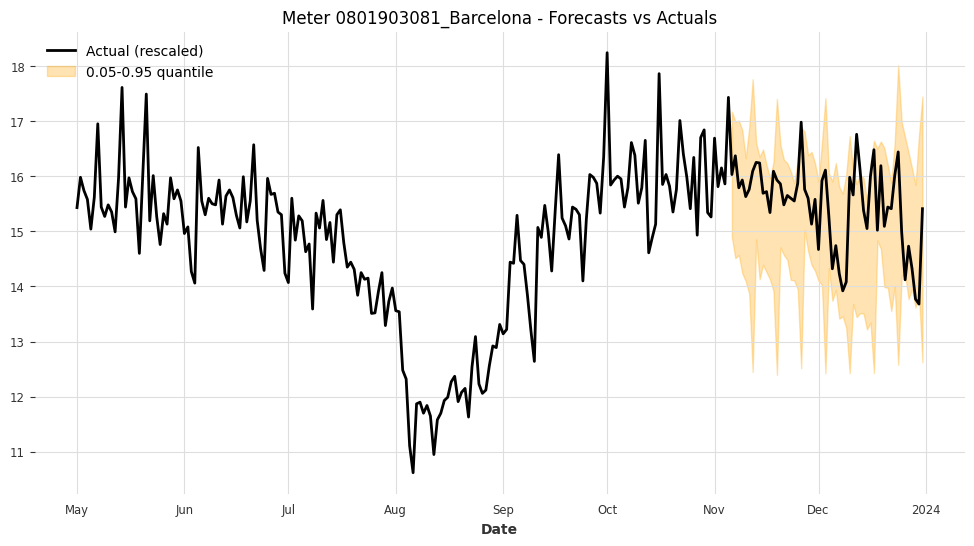

Meter 0801903081_Barcelona - Coverage: 0.9107, Width: 2.6093



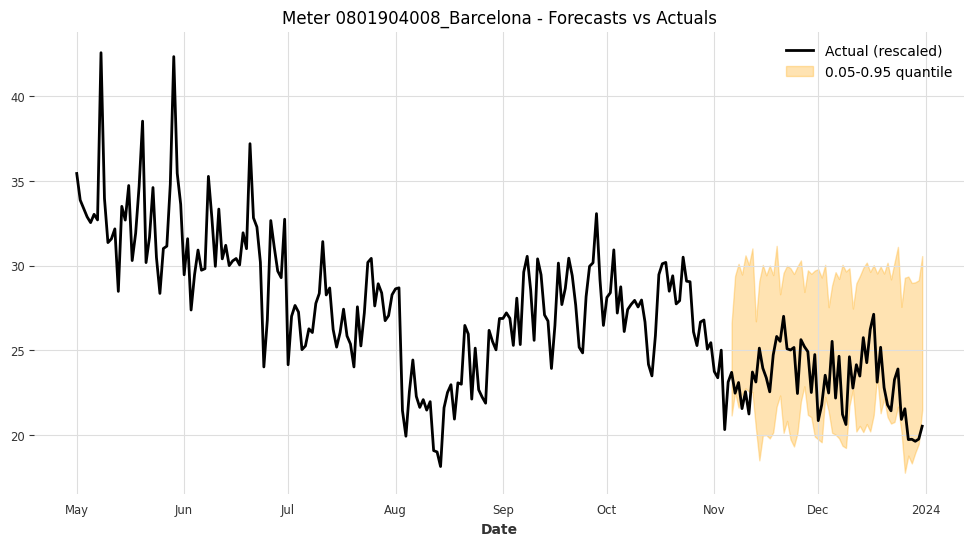

Meter 0801904008_Barcelona - Coverage: 0.8929, Width: 8.7584



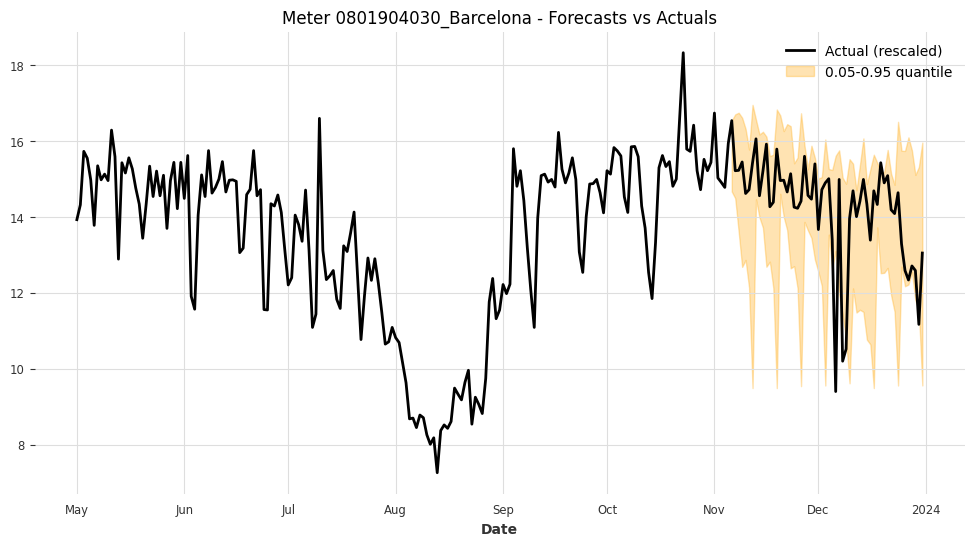

Meter 0801904030_Barcelona - Coverage: 0.8929, Width: 3.5560



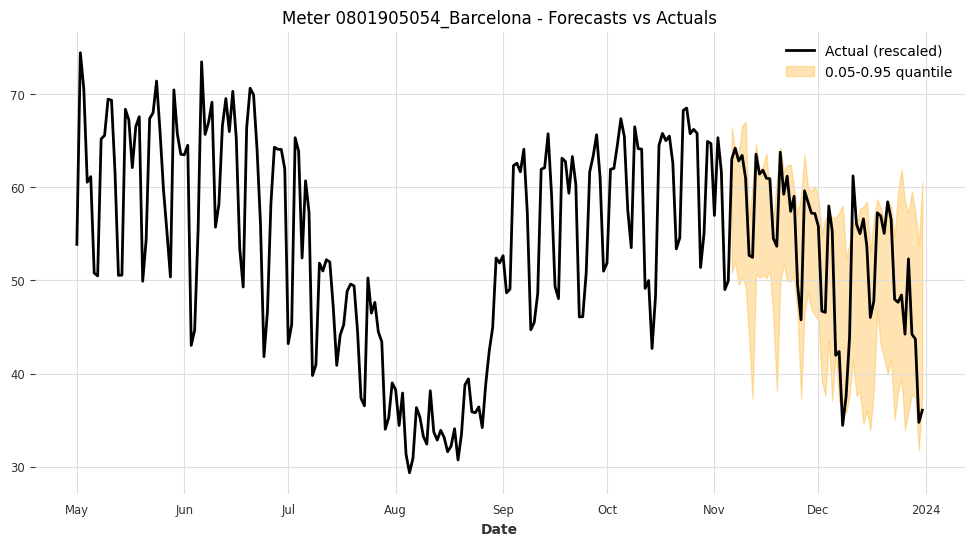

Meter 0801905054_Barcelona - Coverage: 0.8571, Width: 16.5261



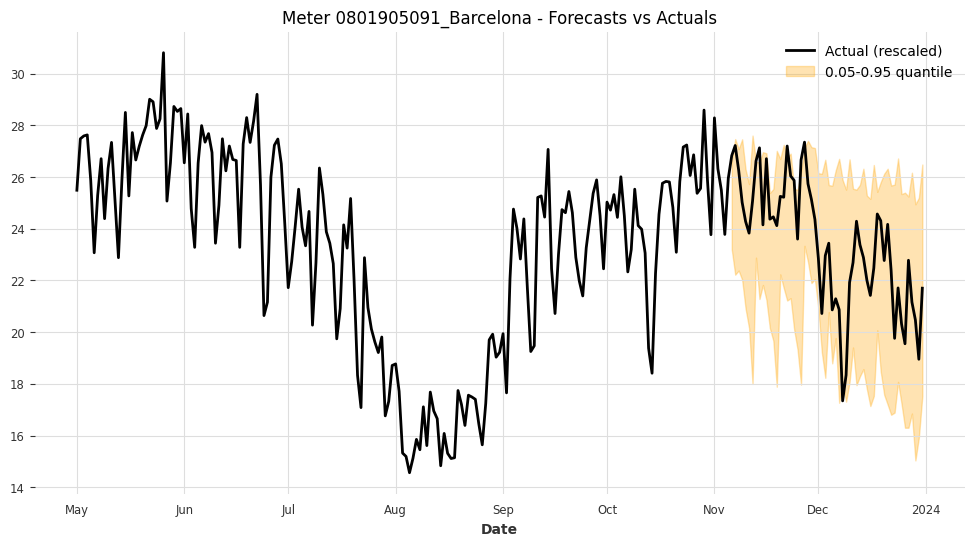

Meter 0801905091_Barcelona - Coverage: 0.8571, Width: 6.8864



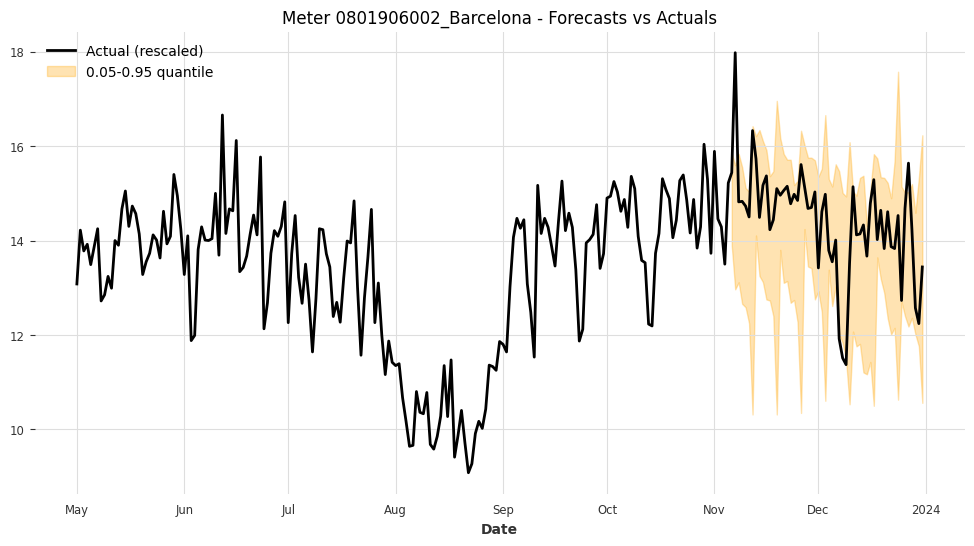

Meter 0801906002_Barcelona - Coverage: 0.8929, Width: 3.2577



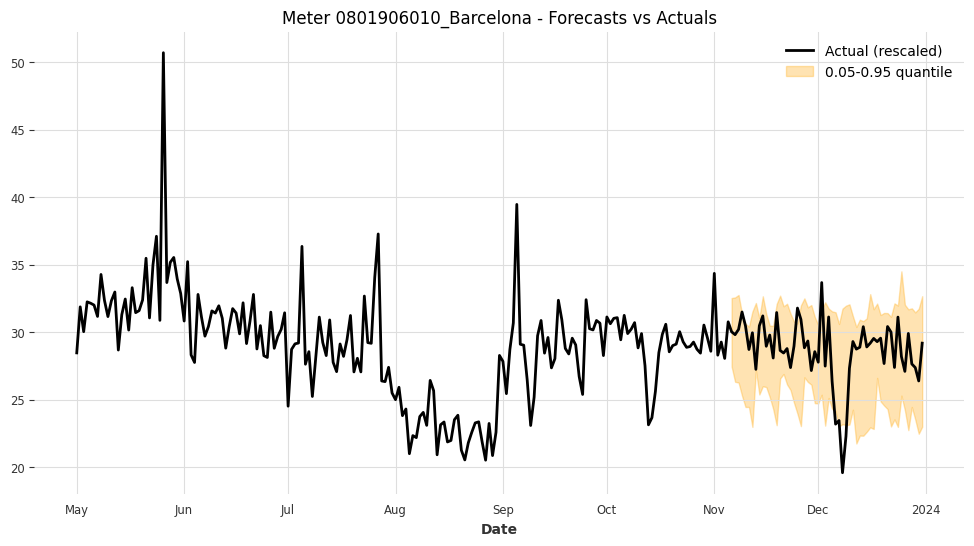

Meter 0801906010_Barcelona - Coverage: 0.8929, Width: 7.2081



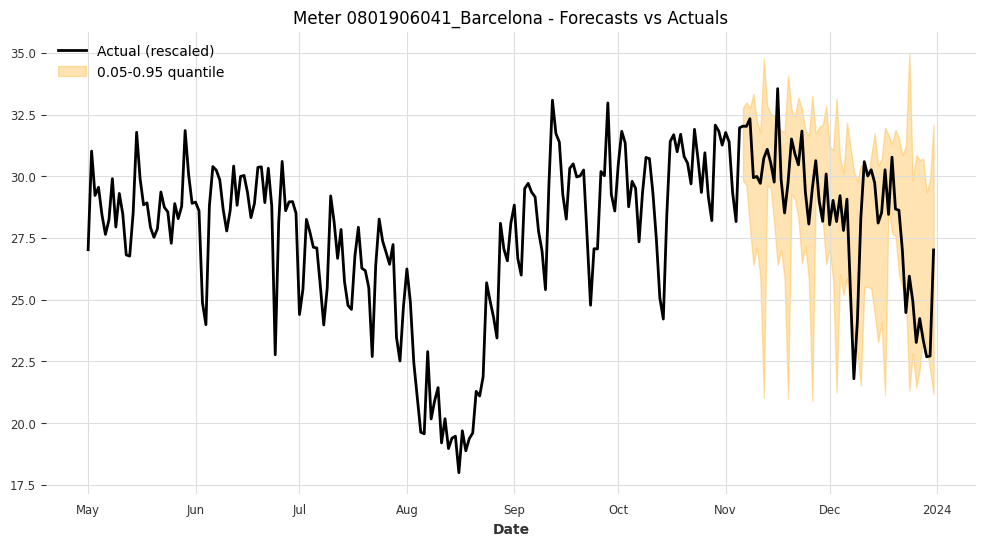

Meter 0801906041_Barcelona - Coverage: 0.8393, Width: 6.2776



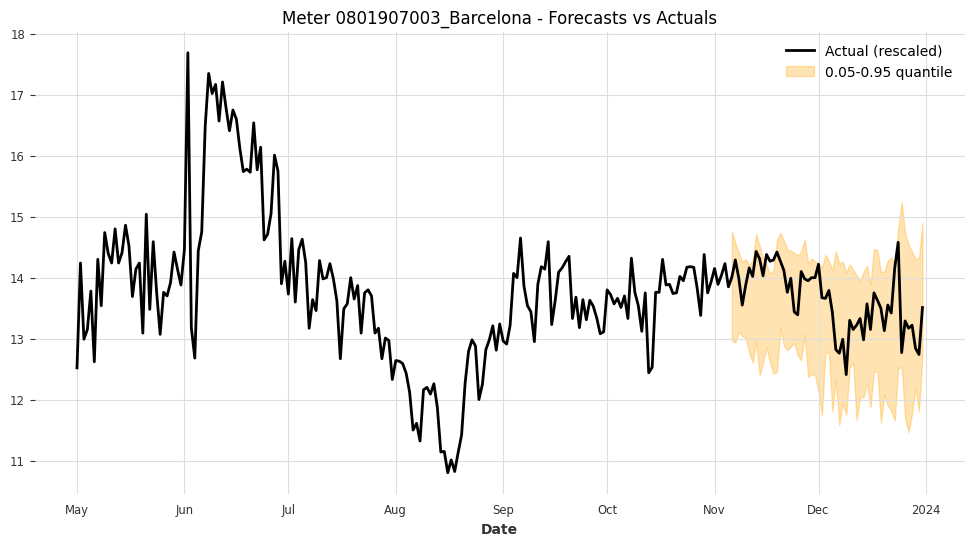

Meter 0801907003_Barcelona - Coverage: 0.9464, Width: 1.9749



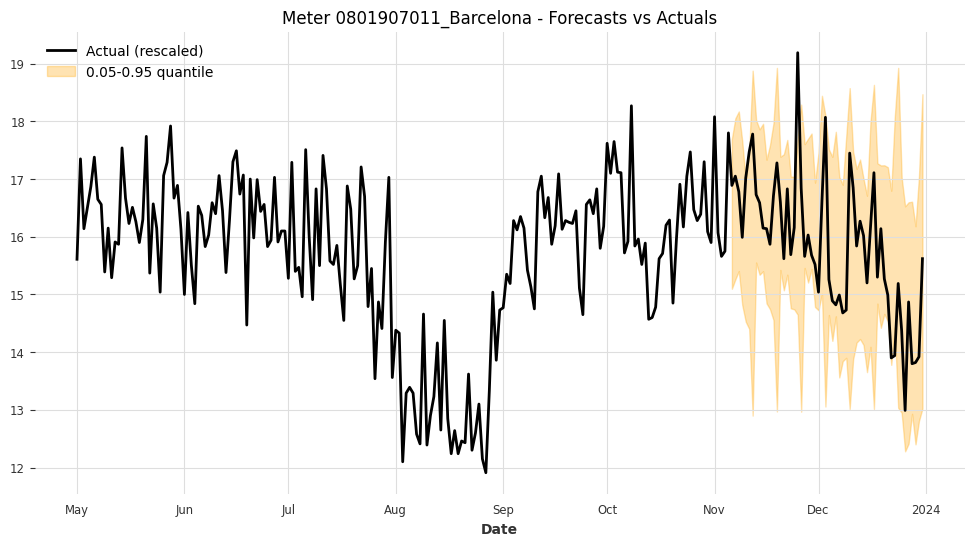

Meter 0801907011_Barcelona - Coverage: 0.9464, Width: 3.3524



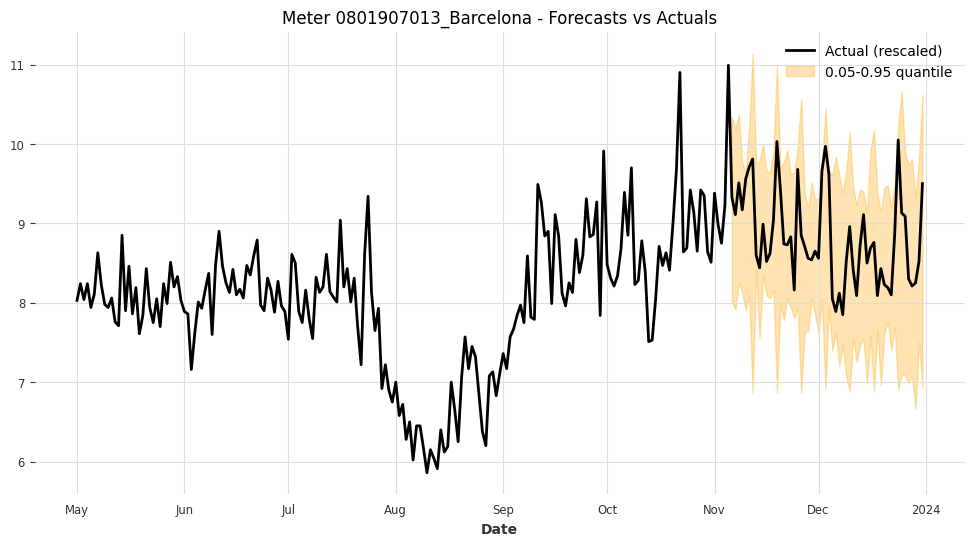

Meter 0801907013_Barcelona - Coverage: 1.0000, Width: 2.2388



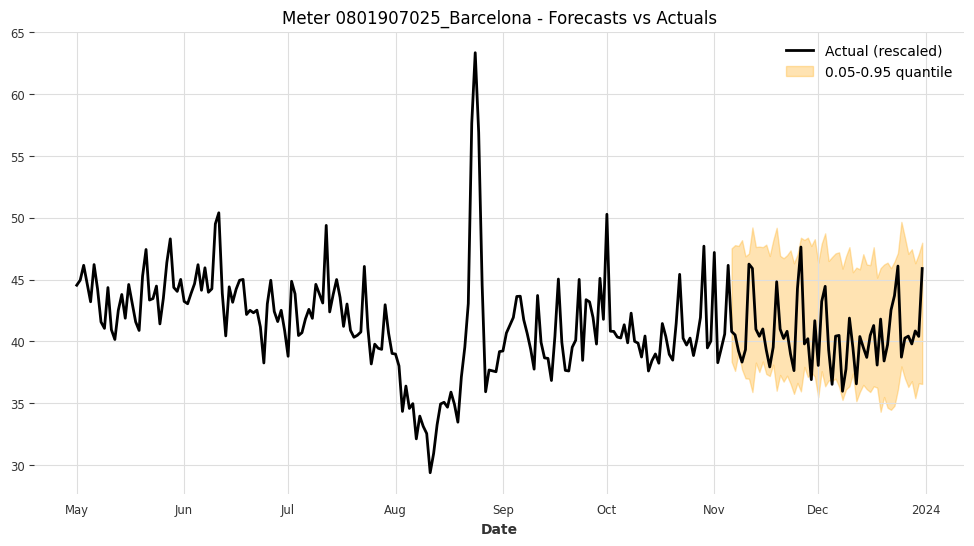

Meter 0801907025_Barcelona - Coverage: 0.9643, Width: 10.5850



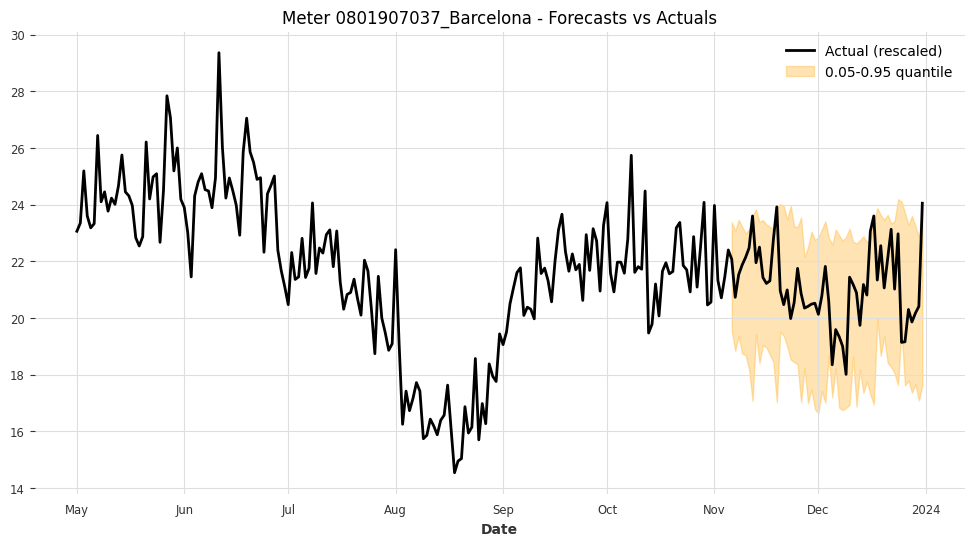

Meter 0801907037_Barcelona - Coverage: 0.8929, Width: 5.2068



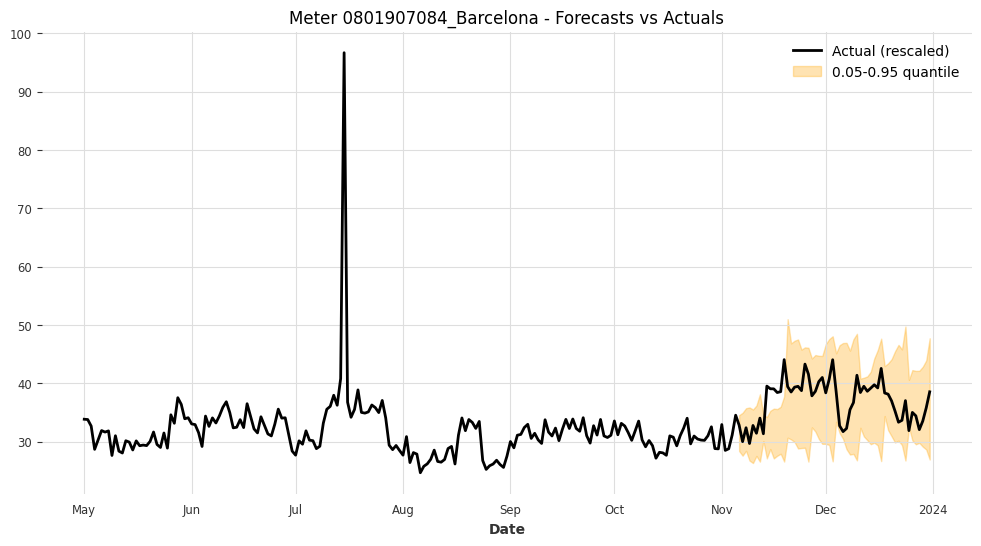

Meter 0801907084_Barcelona - Coverage: 0.8750, Width: 13.6476



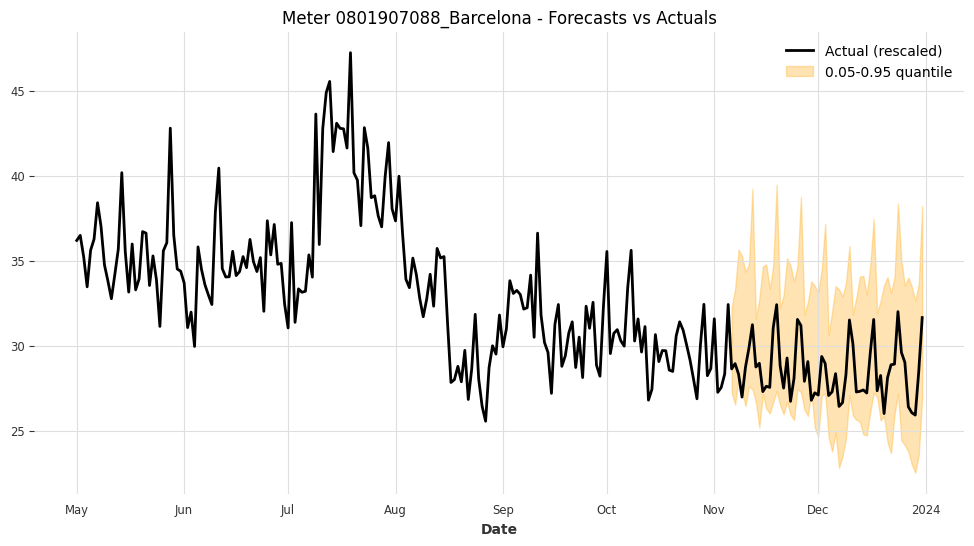

Meter 0801907088_Barcelona - Coverage: 0.9643, Width: 8.3805



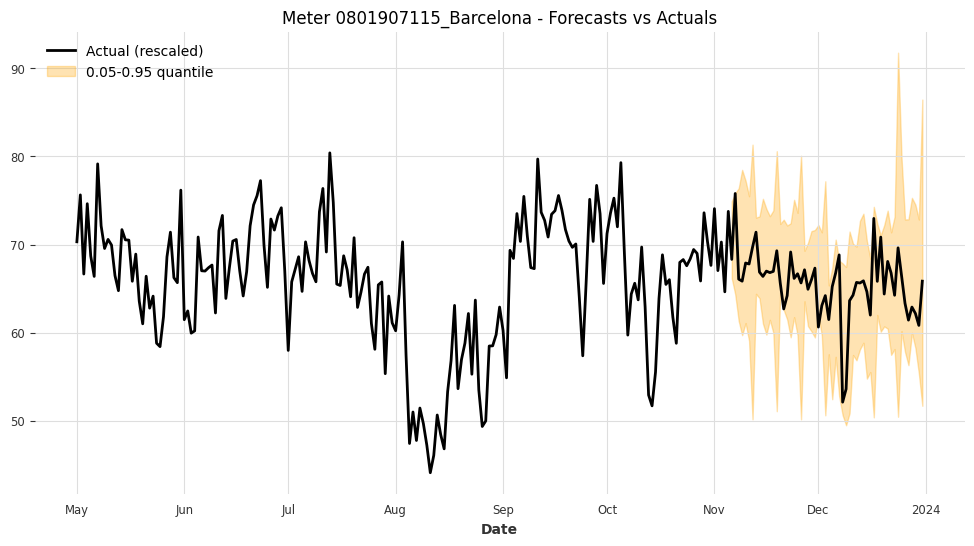

Meter 0801907115_Barcelona - Coverage: 0.9643, Width: 15.5477



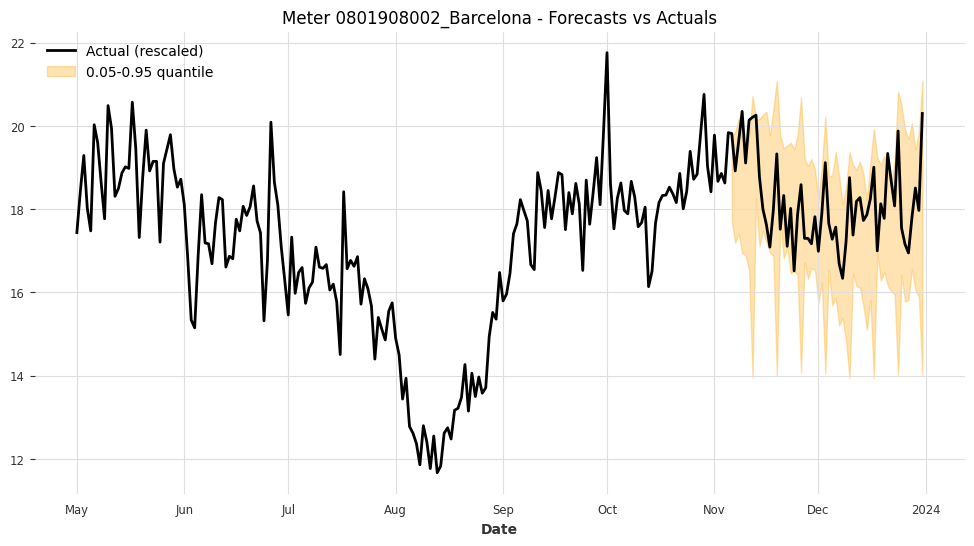

Meter 0801908002_Barcelona - Coverage: 0.8750, Width: 3.4498



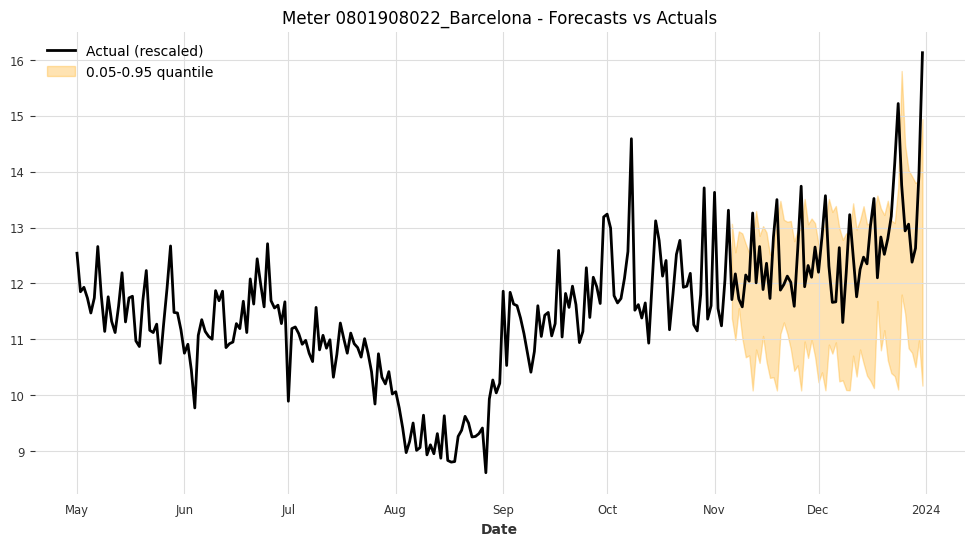

Meter 0801908022_Barcelona - Coverage: 0.7857, Width: 2.5642



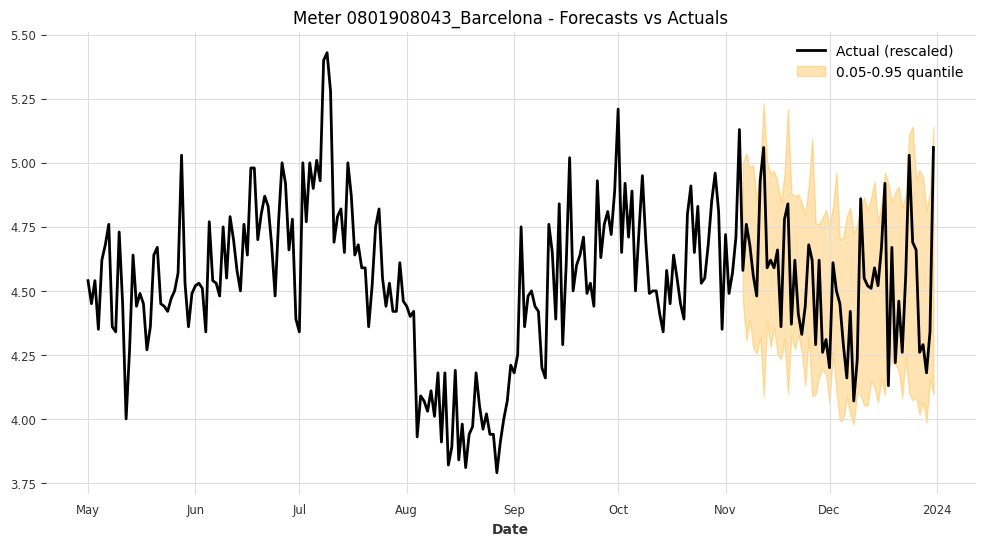

Meter 0801908043_Barcelona - Coverage: 0.9643, Width: 0.7303



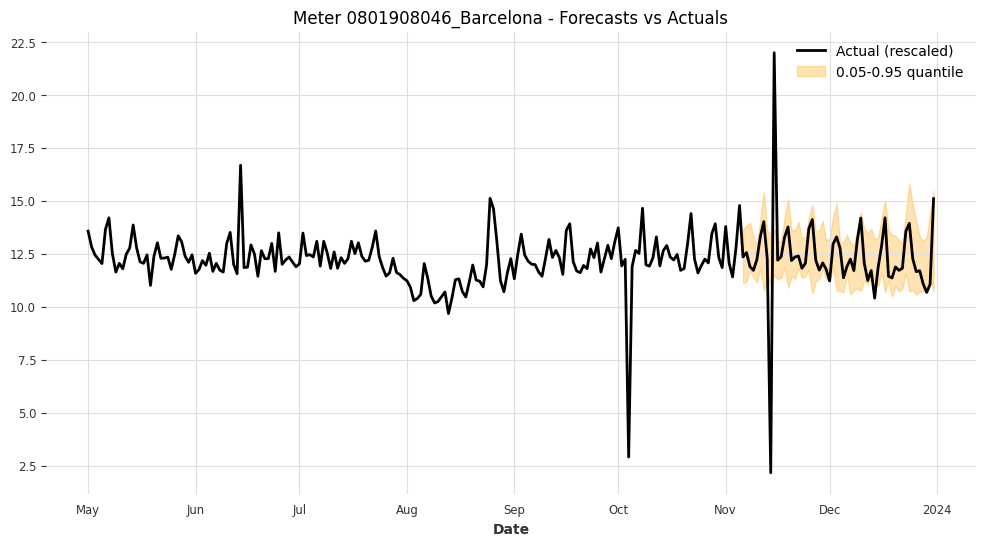

Meter 0801908046_Barcelona - Coverage: 0.8929, Width: 2.6371



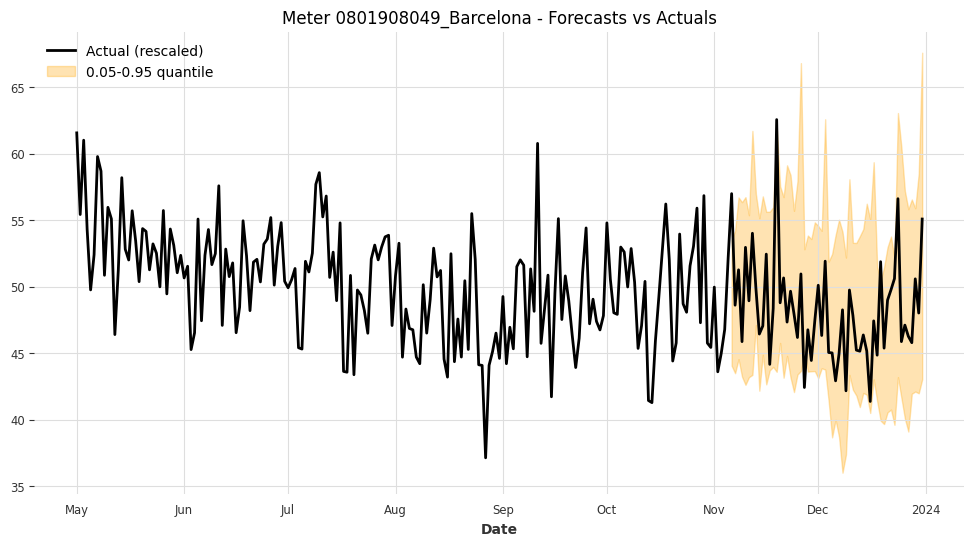

Meter 0801908049_Barcelona - Coverage: 0.9286, Width: 13.8138



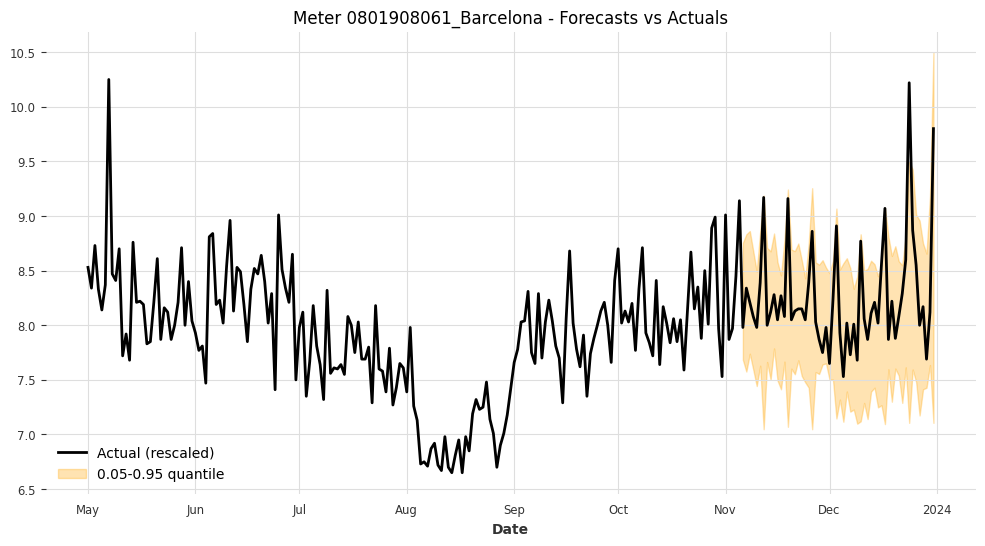

Meter 0801908061_Barcelona - Coverage: 0.9821, Width: 1.3430



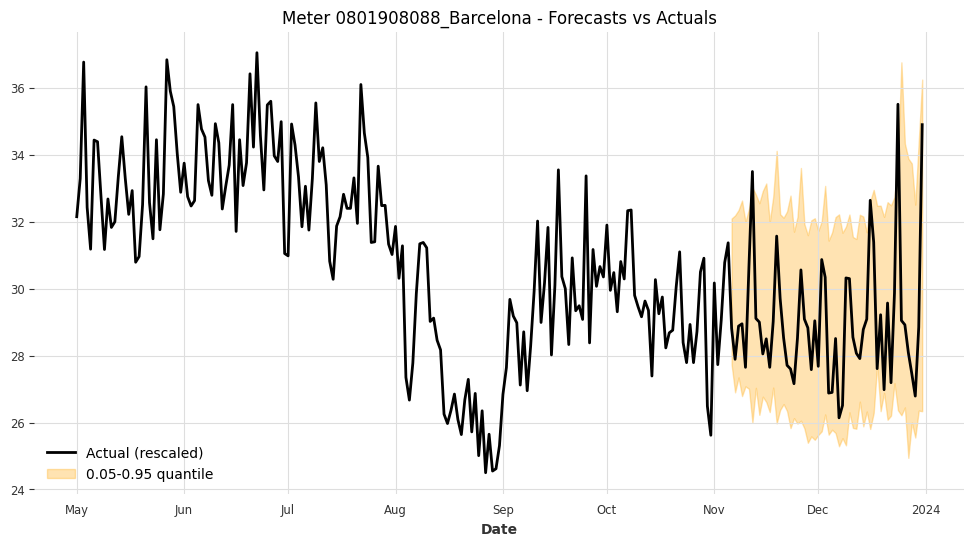

Meter 0801908088_Barcelona - Coverage: 0.9286, Width: 6.3931



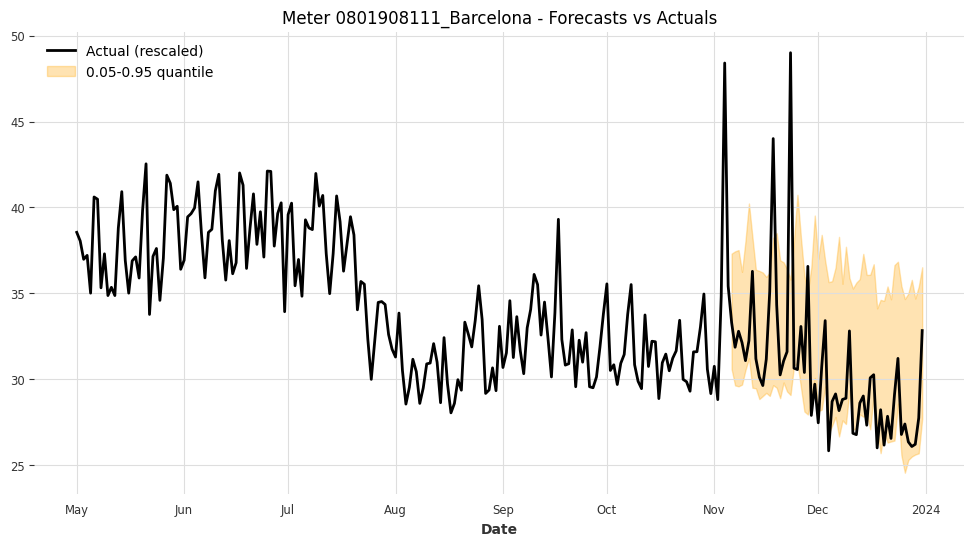

Meter 0801908111_Barcelona - Coverage: 0.7500, Width: 8.3693



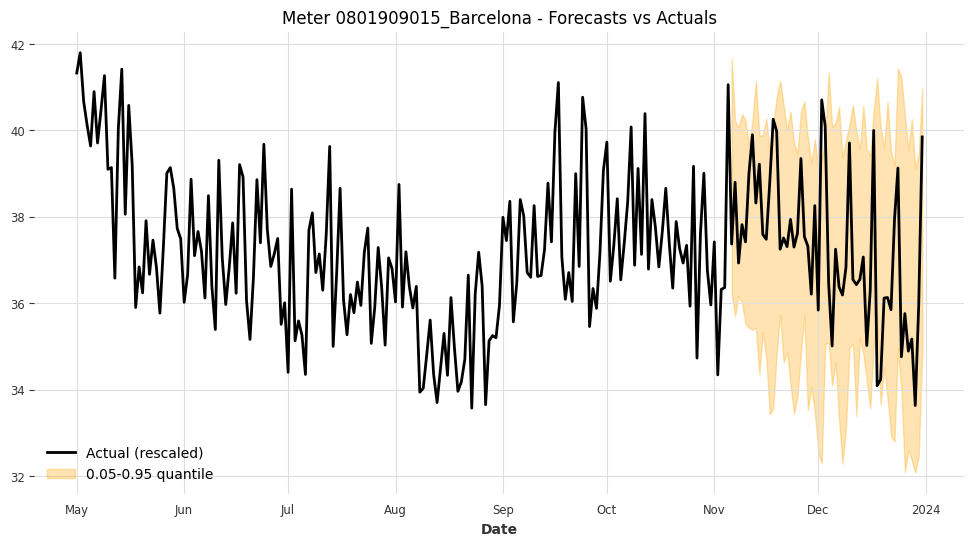

Meter 0801909015_Barcelona - Coverage: 0.9286, Width: 5.8955



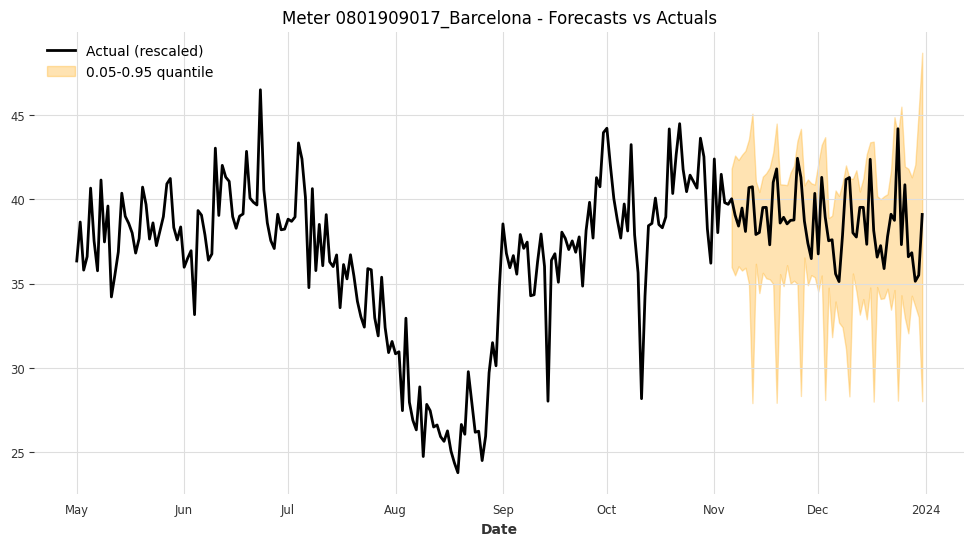

Meter 0801909017_Barcelona - Coverage: 0.9643, Width: 8.4440



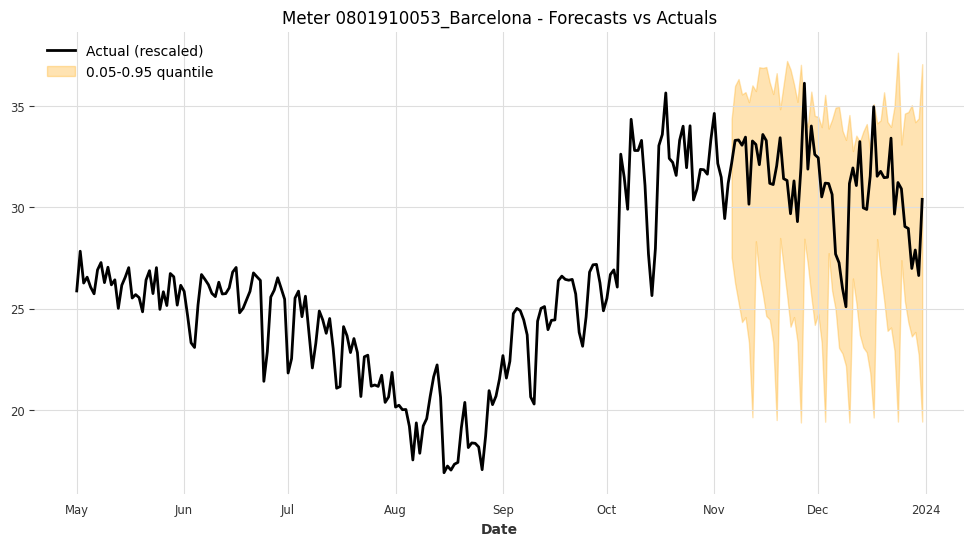

Meter 0801910053_Barcelona - Coverage: 0.9643, Width: 10.8405



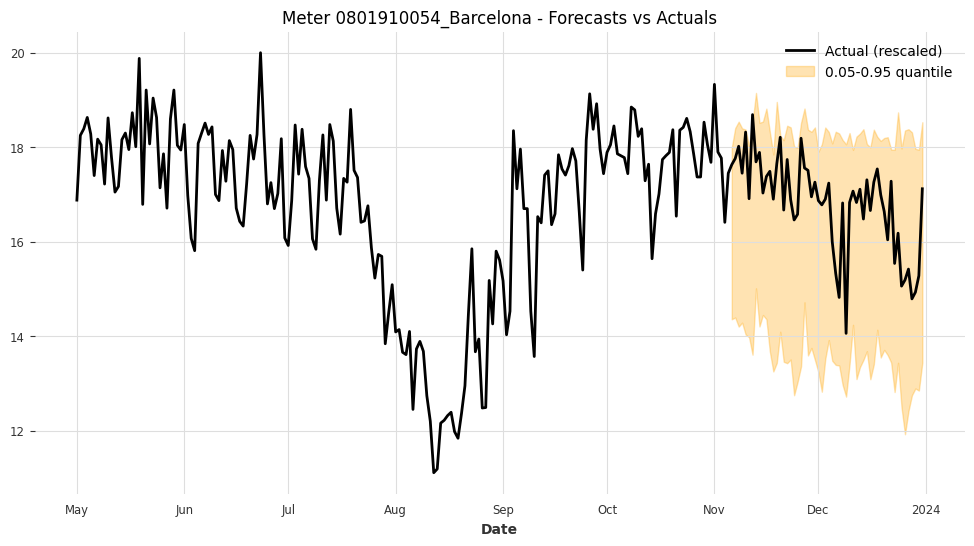

Meter 0801910054_Barcelona - Coverage: 0.9821, Width: 4.7688



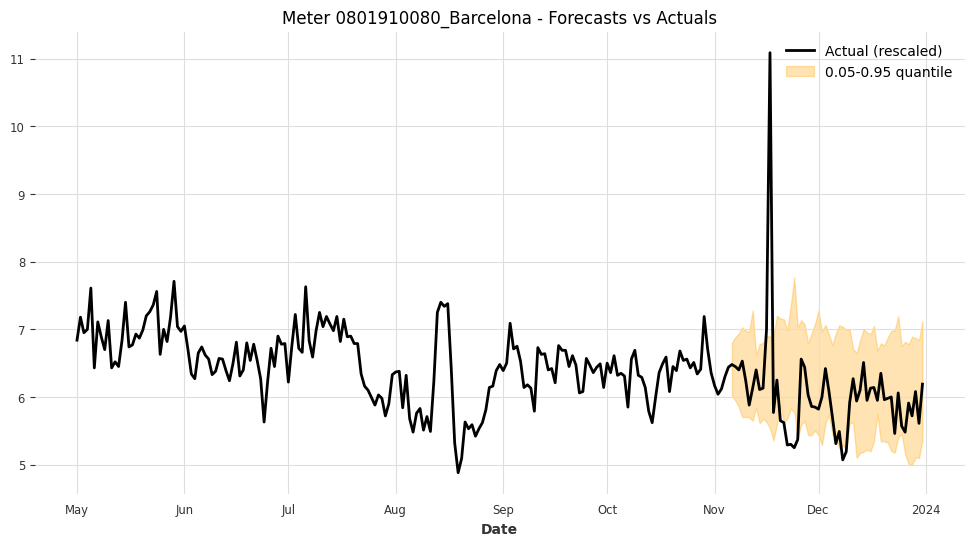

Meter 0801910080_Barcelona - Coverage: 0.8036, Width: 1.4914



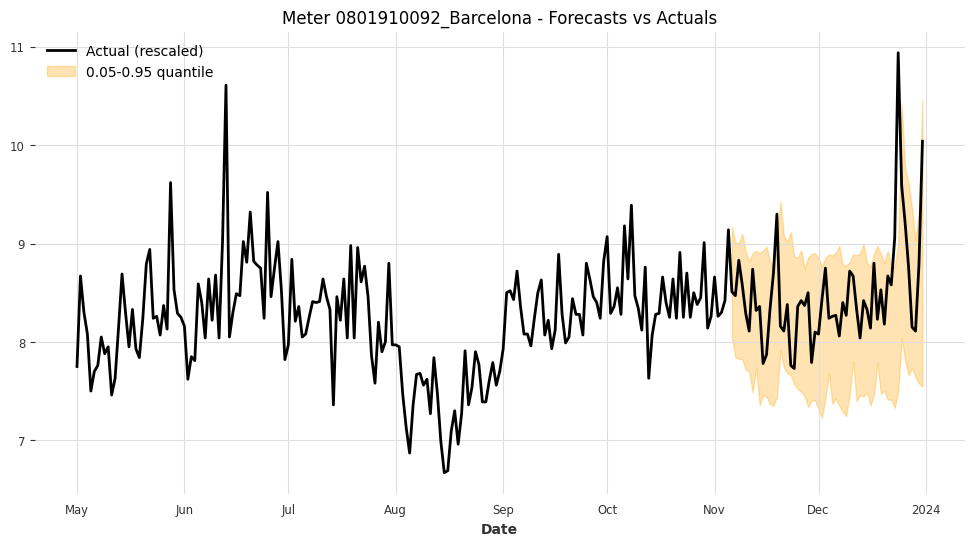

Meter 0801910092_Barcelona - Coverage: 0.9464, Width: 1.4678



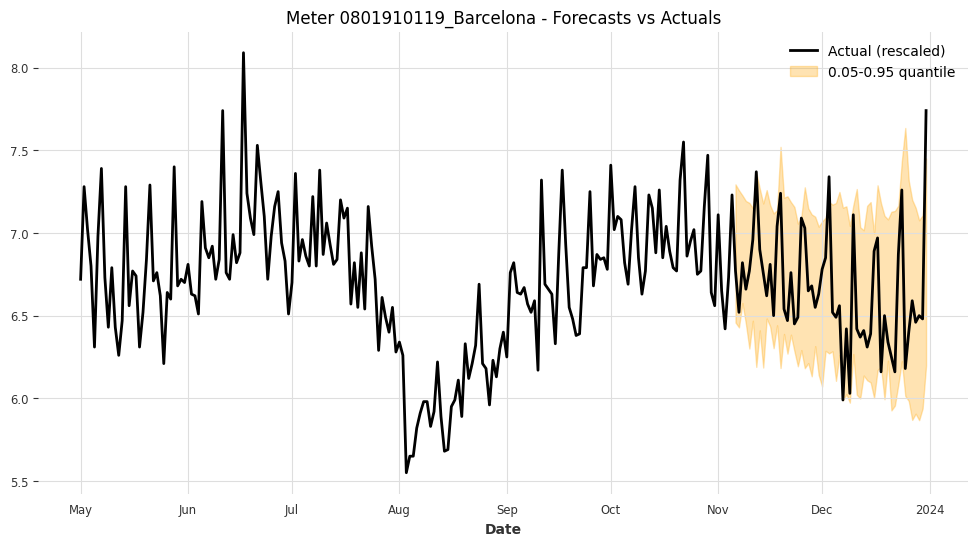

Meter 0801910119_Barcelona - Coverage: 0.9286, Width: 0.9990



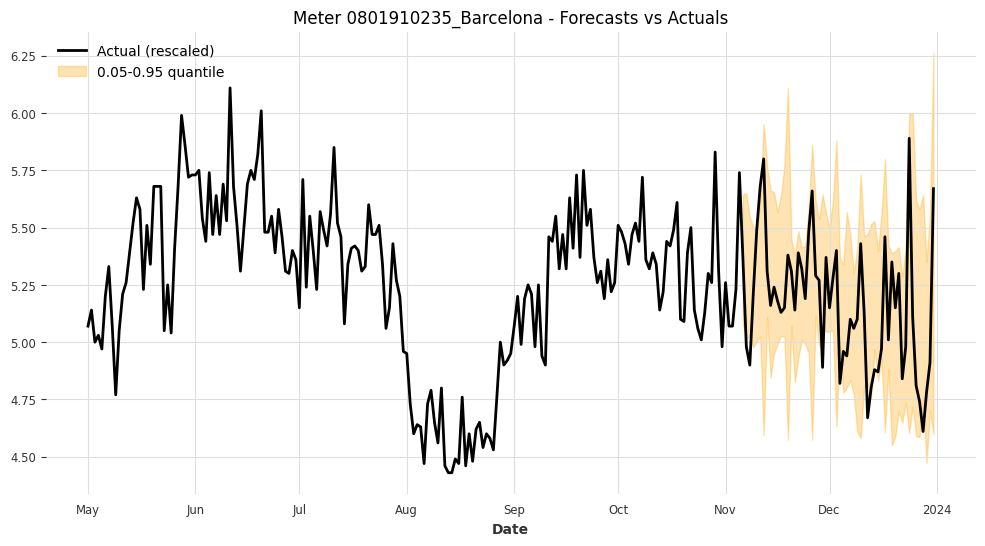

Meter 0801910235_Barcelona - Coverage: 0.8393, Width: 0.7505



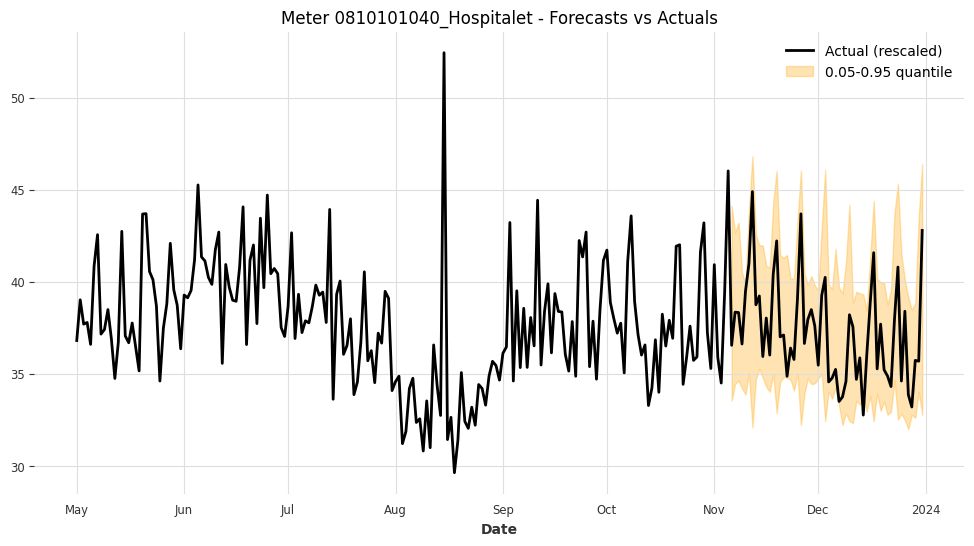

Meter 0810101040_Hospitalet - Coverage: 0.9821, Width: 7.8229



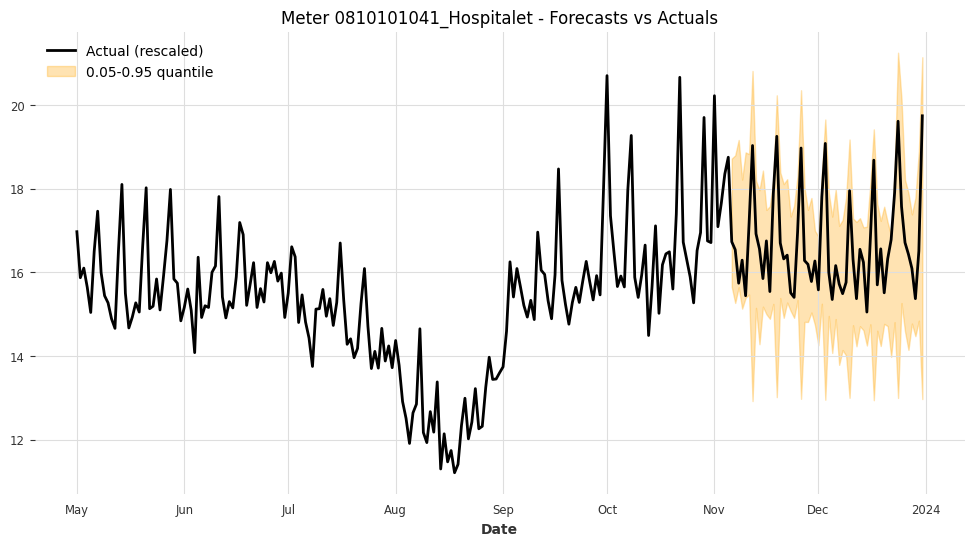

Meter 0810101041_Hospitalet - Coverage: 1.0000, Width: 3.6827



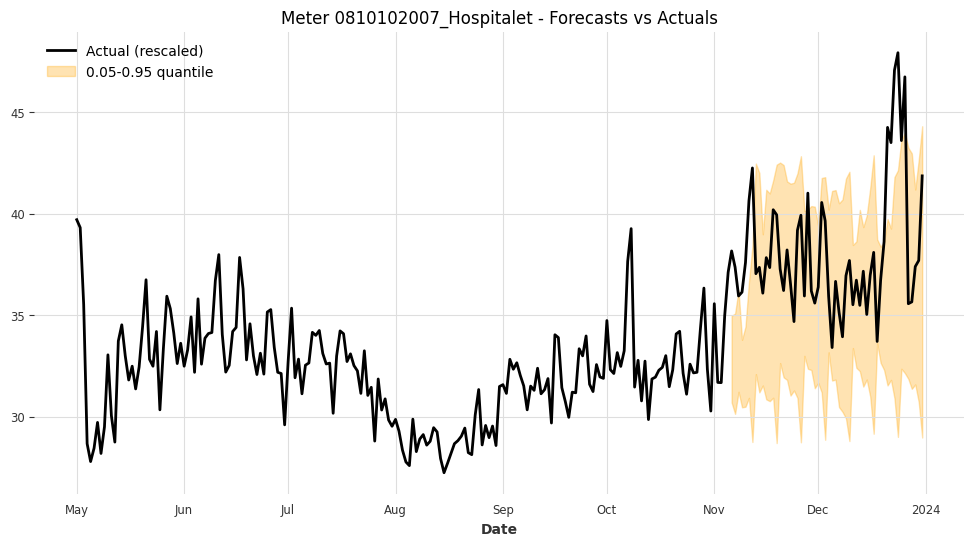

Meter 0810102007_Hospitalet - Coverage: 0.7679, Width: 9.2862



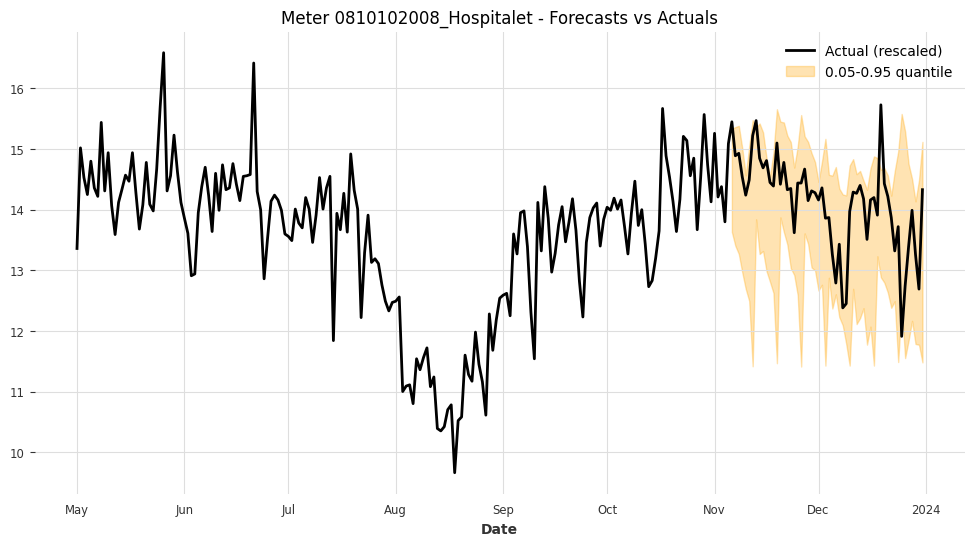

Meter 0810102008_Hospitalet - Coverage: 0.9286, Width: 2.3483



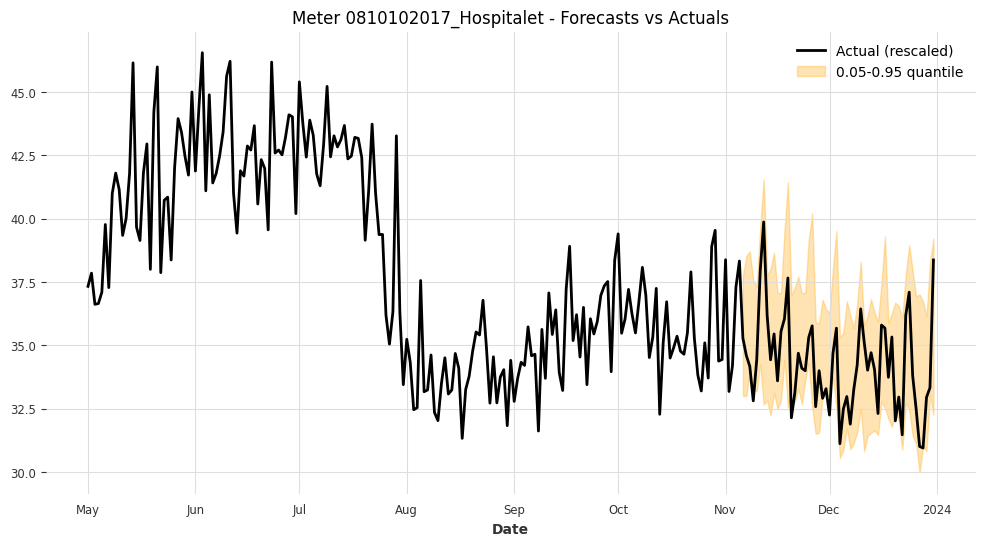

Meter 0810102017_Hospitalet - Coverage: 0.8929, Width: 5.1273



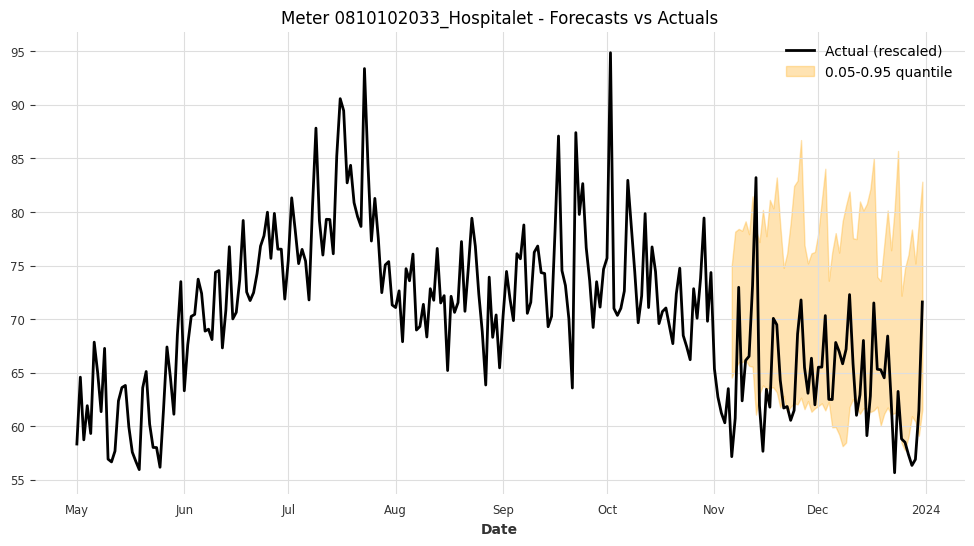

Meter 0810102033_Hospitalet - Coverage: 0.6786, Width: 16.8720



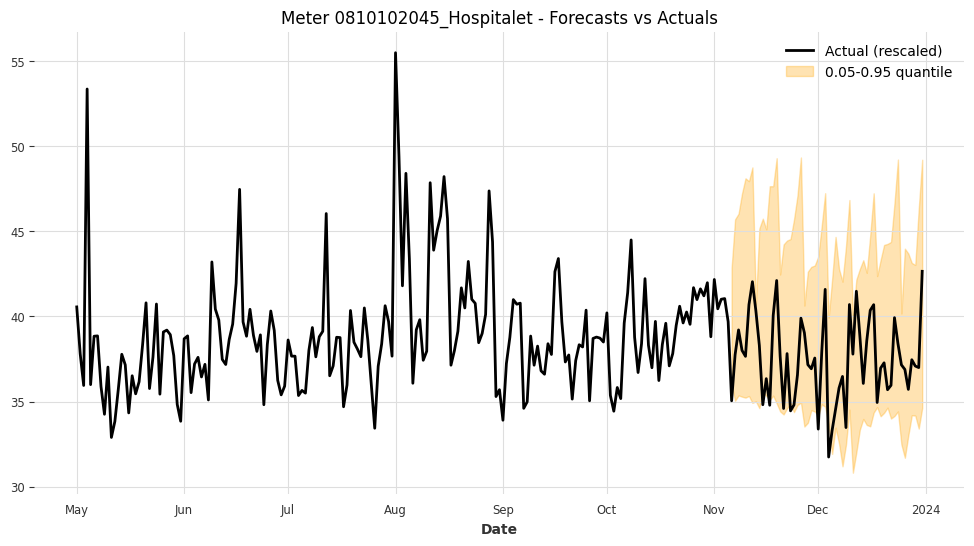

Meter 0810102045_Hospitalet - Coverage: 0.8929, Width: 10.5220



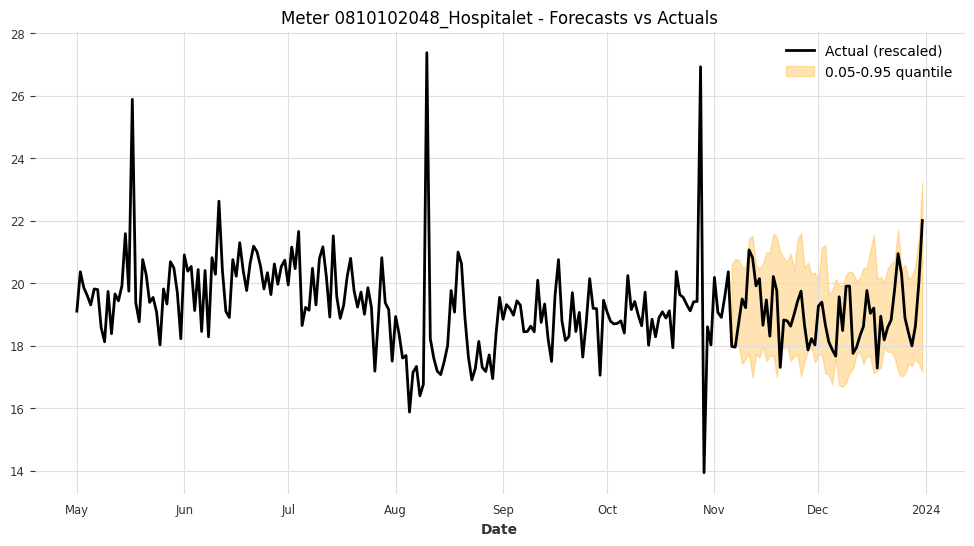

Meter 0810102048_Hospitalet - Coverage: 0.9464, Width: 3.1983



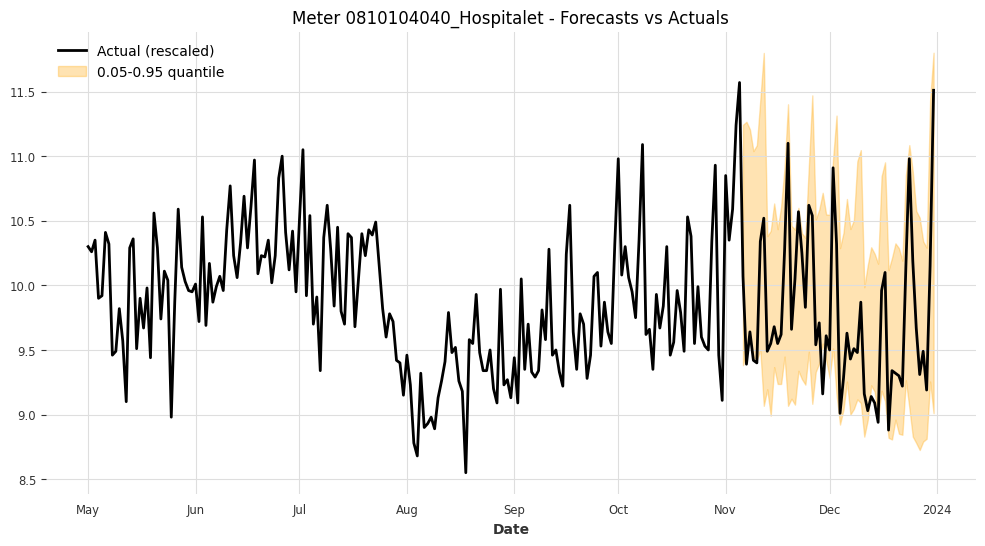

Meter 0810104040_Hospitalet - Coverage: 0.8750, Width: 1.5568



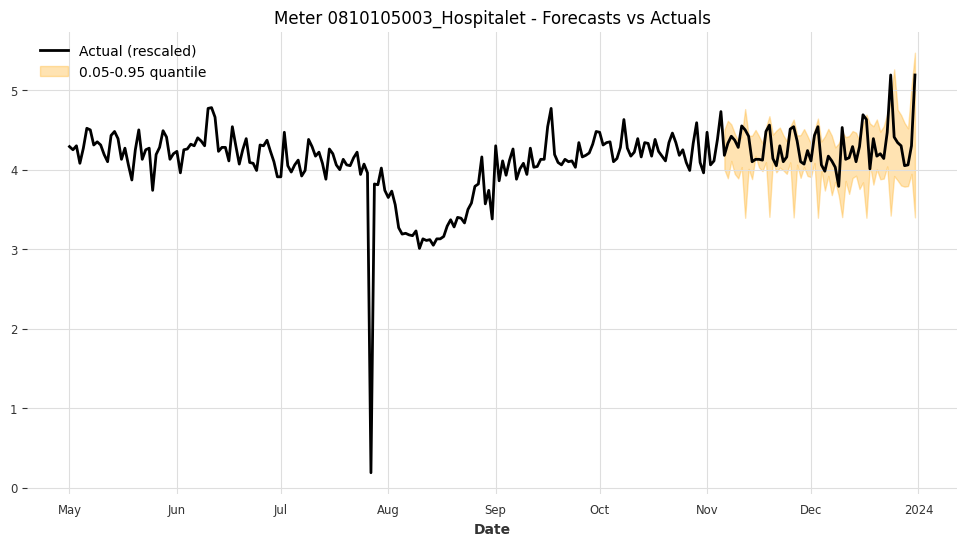

Meter 0810105003_Hospitalet - Coverage: 0.8929, Width: 0.6894



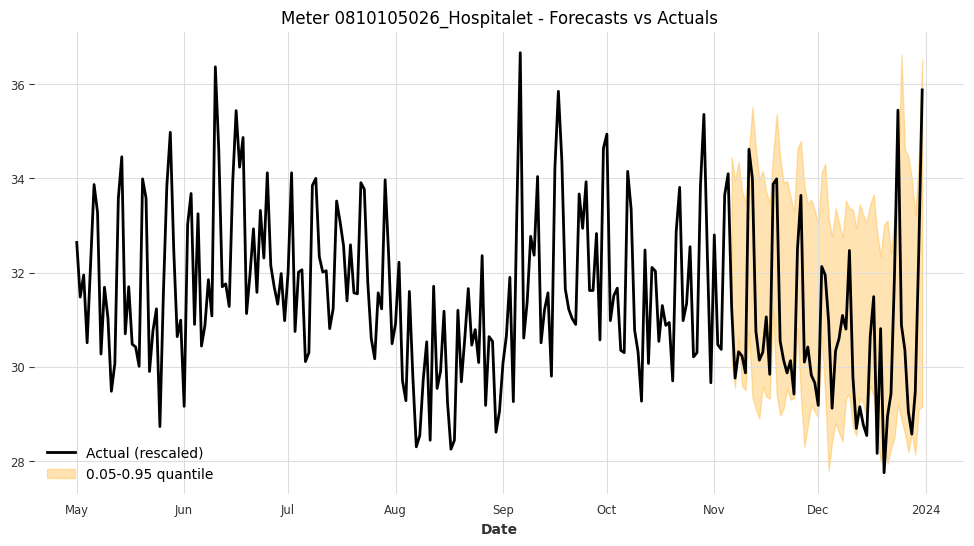

Meter 0810105026_Hospitalet - Coverage: 0.8393, Width: 4.6965



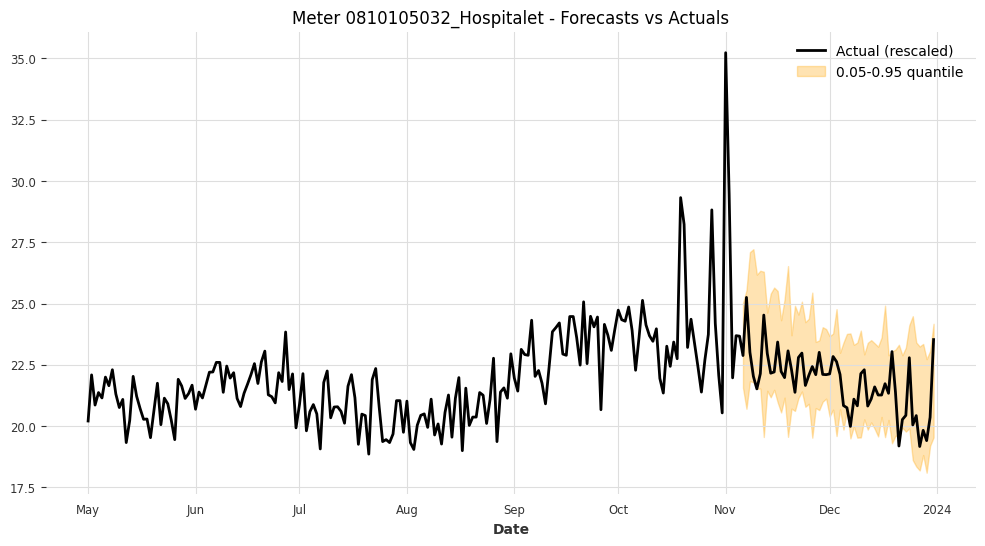

Meter 0810105032_Hospitalet - Coverage: 0.9643, Width: 4.0027



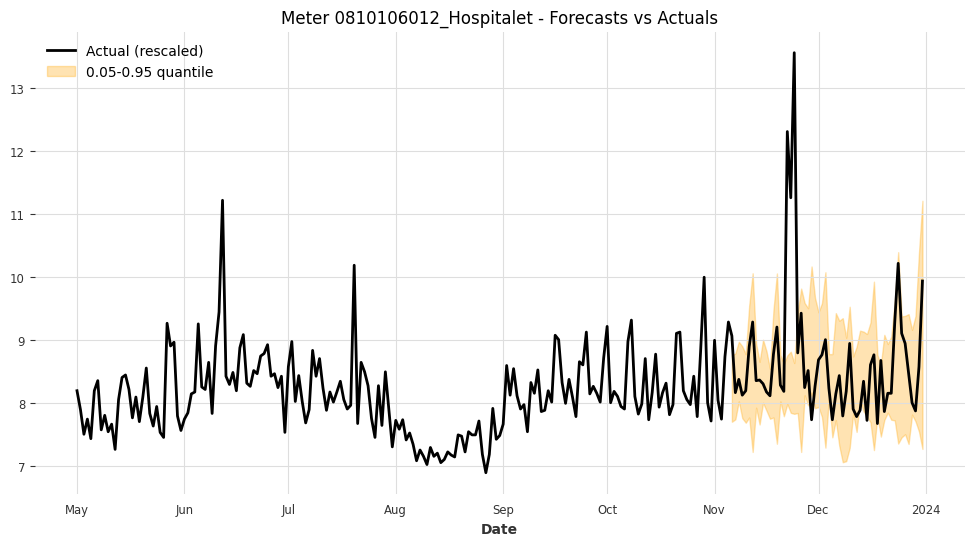

Meter 0810106012_Hospitalet - Coverage: 0.8393, Width: 1.5881



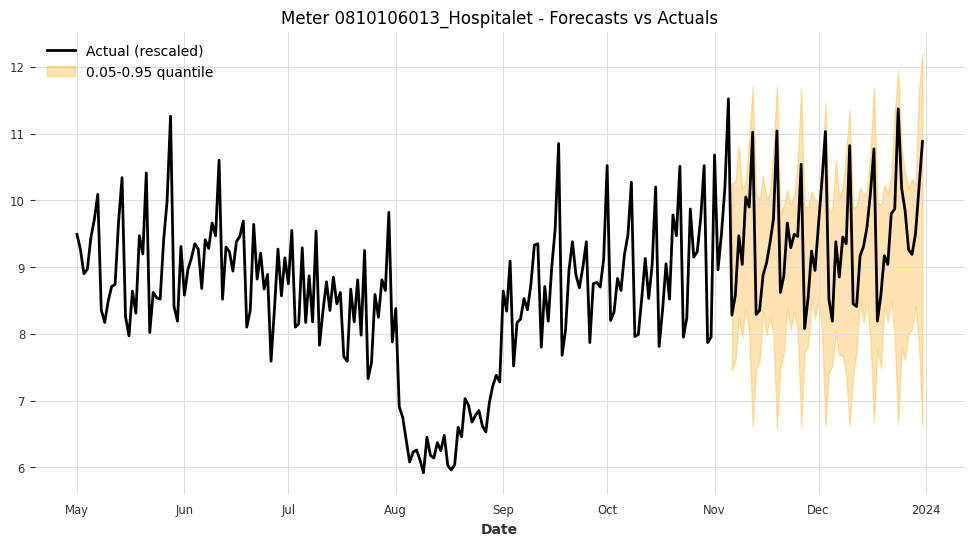

Meter 0810106013_Hospitalet - Coverage: 1.0000, Width: 2.7052



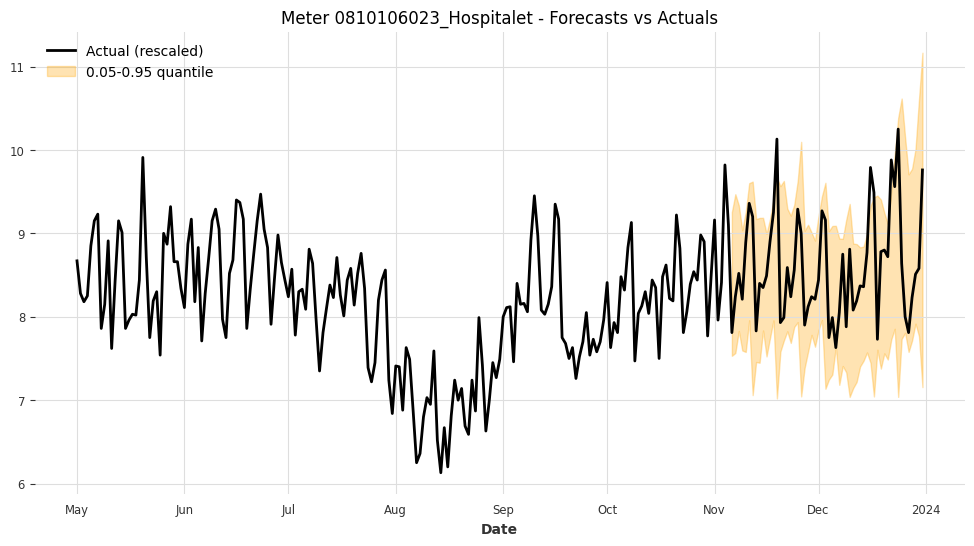

Meter 0810106023_Hospitalet - Coverage: 0.9107, Width: 1.8821



In [14]:
import matplotlib.pyplot as plt
from darts import concatenate  # Darts utility to merge TimeSeries

for meter_id, hfcs in all_hfcs.items():
    # Get the actual time series
    ts = scaled_calib_test_series[meter_id]

    # Get scaler and results
    scaler = scalers_test[meter_id]
    df_result = all_bt_results[meter_id]
    coverage = df_result["Coverage"].iloc[0]
    width = df_result["Width rescaled"].iloc[0]

    # Start a new plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot actuals (rescaled)
    ts_orig = scaler.inverse_transform(ts)
    ts_orig.plot(ax=ax, label='Actual (rescaled)', lw=2)

    full_lower = []
    full_upper = []

    # Collect lower and upper quantiles from each forecast window
    for forecast in hfcs:
        if ('Consumption per meter_q0.05' in forecast.components
            and 'Consumption per meter_q0.95' in forecast.components):

            lower = forecast['Consumption per meter_q0.05']
            upper = forecast['Consumption per meter_q0.95']
            lower_orig = scaler.inverse_transform(lower)
            upper_orig = scaler.inverse_transform(upper)
            full_lower.append(lower_orig)
            full_upper.append(upper_orig)


    if full_lower and full_upper:
        # Concatenate all the TimeSeries pieces into full series
        combined_lower = concatenate(full_lower)
        combined_upper = concatenate(full_upper)

        # Plot the quantile area as a filled region
        ax.fill_between(
            combined_lower.time_index,
            combined_lower.values().flatten(),
            combined_upper.values().flatten(),
            color='orange',
            alpha=0.3,
            label='0.05-0.95 quantile'
        )

    ax.set_title(f"Meter {meter_id} - Forecasts vs Actuals")
    ax.legend()
    plt.show()

    # Print the metrics below each plot
    print(f"Meter {meter_id} - Coverage: {coverage:.4f}, Width: {width:.4f}\n")


In [ ]:
# Specific test

In [ ]:
# Load model
model = LightGBMModel.load("/content/drive/MyDrive/Colab Notebooks/TFG/data/02_models/lightGBM/covariates/lightgbm_model_covariates.pkl")

In [ ]:
# Load the test data
test_data = joblib.load('/content/drive/MyDrive/Colab Notebooks/TFG/data/01_datasets/train_test_reduced/scaled_test_reduced.pkl')

# Extract components
scaled_val_series = test_data['validation']        # validation not used in our case
scaled_calib_test_series = test_data['calib_test']
scalers_test = test_data['scalers']           # the scalers to reescale the series later

# Reuse the same sorted meter IDs to align
meter_ids_test = sorted(scaled_calib_test_series.keys())

# Build aligned lists
test_series_scaled = [scaled_calib_test_series[meter_id] for meter_id in meter_ids_test]

print(f"Loaded {len(test_series_scaled)} time series for testing.")

Loaded 60 time series for testing.


In [ ]:
# We build the future covariates for the test set
future_covariates_test = []

for test_ts in test_series_scaled:
    test_cov = concatenate([
        datetime_attribute_timeseries(test_ts, "day_of_week", one_hot=True),
        datetime_attribute_timeseries(test_ts, "month", one_hot=True),
        is_weekend_timeseries.slice_intersect(test_ts),
        holiday_timeseries.slice_intersect(test_ts),
        day_of_year_timeseries.slice_intersect(test_ts)
    ], axis=1)

    future_covariates_test.append(test_cov)

In [ ]:
# Constants
start_date = pd.Timestamp("2023-11-6")
horizon = 7
quantiles = [0.05, 0.5, 0.95]
pred_kwargs={"predict_likelihood_parameters": True, "verbose": True}

# Initialize the conformal quantile regression model
cp_model = ConformalQRModel(
    model=model,
    quantiles=quantiles,
    symmetric=False
    # if cal_length is None, it considers all calibration scores
)
q_interval = cp_model.q_interval  # [(0.05, 0.95)]
q_range = cp_model.interval_range  # [0.9]

# Prepare to collect results
all_hfcs = {}
all_bt_results = {}

# We loop over each time series
for meter_id, ts, fcov in zip(meter_ids_test, test_series_scaled, future_covariates_test):
    # Historical forecasts
    hfcs = cp_model.historical_forecasts(
        series=ts,
        future_covariates=fcov,
        forecast_horizon=7,
        start=start_date,
        last_points_only=False,
        stride=7,
        **pred_kwargs,
    )

    scaler = scalers_test[meter_id]
    widths = []

    for forecast in hfcs:
        q05 = forecast["Consumption per meter_q0.05"]
        q95 = forecast["Consumption per meter_q0.95"]
        q05_orig = scaler.inverse_transform(q05)
        q95_orig = scaler.inverse_transform(q95)
        width = (q95_orig - q05_orig).values()
        widths.append(width)

    mean_width = np.mean([np.mean(w) for w in widths])

    # We evaluate the already-generated historical forecasts
    bt = cp_model.backtest(
        ts,
        future_covariates=fcov,
        historical_forecasts=hfcs,
        last_points_only=False,
        metric=[metrics.mic, metrics.miw],
        metric_kwargs={"q_interval": q_interval},
    )
    df_results = pd.DataFrame({"Interval": q_range, "Coverage": bt[0], "Width": bt[1], "Width rescaled": mean_width})
    print(f"Results for meter {meter_id}:\n", df_results, "\n")

    # Store results
    all_hfcs[meter_id] = hfcs
    all_bt_results[meter_id] = df_results

# We combine results across meters
combined_results = pd.concat(all_bt_results.values(), keys=all_bt_results.keys())
combined_results.reset_index(level=1, drop=True, inplace=True)

conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 445.52it/s]


Results for meter 0801902043_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.226287        2.686031 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 434.28it/s]


Results for meter 0801903008_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.166735        3.294692 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 459.59it/s]


Results for meter 0801903021_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.396707        1.626499 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 460.32it/s]


Results for meter 0801903026_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.312438        2.246428 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 449.57it/s]


Results for meter 0801903035_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.286629        0.802561 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 450.49it/s]


Results for meter 0801903037_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.371583        2.184907 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 443.07it/s]


Results for meter 0801903213_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9       1.0  0.325245        0.497624 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 271.97it/s]


Results for meter 0801904027_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.227303         3.61411 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 481.15it/s]


Results for meter 0801904047_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.210178          3.1926 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 436.60it/s]


Results for meter 0801904049_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.473767        4.259168 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 453.75it/s]


Results for meter 0801905057_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.305983        3.374993 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 312.20it/s]


Results for meter 0801906071_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.302404        1.599718 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 424.89it/s]


Results for meter 0801910007_Barcelona:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.360366        1.178397 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 271.93it/s]


Results for meter 0807302003_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9       1.0  0.225572        7.112288 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 309.92it/s]


Results for meter 0807710008_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.172501       71.760422 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 428.38it/s]


Results for meter 0810101004_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  0.338951        7.802644 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 426.21it/s]


Results for meter 0810101011_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.280463        4.204135 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 374.84it/s]


Results for meter 0810101018_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.261253        1.316716 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 322.20it/s]


Results for meter 0810101019_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.232659        1.642574 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 416.11it/s]


Results for meter 0810101024_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.417453        3.594273 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 433.56it/s]


Results for meter 0810101029_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  0.253506        6.264123 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 430.16it/s]


Results for meter 0810101033_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.381932        5.847374 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 422.43it/s]


Results for meter 0810101039_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.316222        4.642146 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 438.59it/s]


Results for meter 0810101040_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9       1.0  0.395172        7.903439 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 458.70it/s]


Results for meter 0810102005_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.330574        3.120614 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 307.20it/s]


Results for meter 0810102007_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9      0.75  0.551286        7.734538 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 452.73it/s]


Results for meter 0810102016_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.341862        4.881787 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 279.09it/s]


Results for meter 0810102024_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  0.470701         3.35139 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 435.96it/s]


Results for meter 0810102034_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.263719        7.286548 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 439.91it/s]


Results for meter 0810102038_Hospitalet:
    Interval  Coverage    Width  Width rescaled
0       0.9  0.857143  0.51651        7.339609 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 427.73it/s]


Results for meter 0810102039_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.839286  0.455836        6.910476 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 445.56it/s]


Results for meter 0810102045_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.455267       11.281505 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 285.49it/s]


Results for meter 0810102048_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  0.138926        3.364782 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 440.02it/s]


Results for meter 0810102049_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.455403        4.321771 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 441.94it/s]


Results for meter 0810103002_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.857143  0.755903         1.48157 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 442.80it/s]


Results for meter 0810103006_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.200963        5.219008 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 324.61it/s]


Results for meter 0810103011_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  0.367773        4.236741 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 430.83it/s]


Results for meter 0810103012_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.299449        0.455162 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 421.27it/s]


Results for meter 0810103018_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.367571         2.26424 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 418.37it/s]


Results for meter 0810103022_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.287748        3.737843 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 431.34it/s]


Results for meter 0810104007_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.415548         4.93671 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 404.38it/s]


Results for meter 0810104010_Hospitalet:
    Interval  Coverage    Width  Width rescaled
0       0.9  0.910714  0.39734        2.682043 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 438.61it/s]


Results for meter 0810104011_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.133258        3.651267 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 279.12it/s]


Results for meter 0810104033_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.366008        4.121245 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 406.06it/s]


Results for meter 0810104035_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.473967        1.099603 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 377.52it/s]


Results for meter 0810104040_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.368656        1.655267 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 443.34it/s]


Results for meter 0810105001_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.250663        0.817161 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 310.33it/s]


Results for meter 0810105007_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.982143  0.334492        6.268376 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 368.13it/s]


Results for meter 0810105018_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.438197        3.054233 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 416.56it/s]


Results for meter 0810106005_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.910714  0.139084        1.318513 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 249.72it/s]


Results for meter 0810106008_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.308291        1.686354 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 404.16it/s]


Results for meter 0810106010_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.946429  0.250741        1.266243 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 450.61it/s]


Results for meter 0810106014_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.439795        1.741587 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 489.23it/s]


Results for meter 0810106016_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.229267        0.898728 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 325.55it/s]


Results for meter 0810106019_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.283383         1.20721 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 456.11it/s]


Results for meter 0810106021_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.964286  0.156185          1.8711 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 378.78it/s]


Results for meter 0810106022_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.892857  0.344414        1.050462 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 431.40it/s]


Results for meter 0810106023_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.304022        1.818049 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 445.03it/s]


Results for meter 0810106026_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9     0.875  0.166731        0.571888 



conformal forecasts: 100%|██████████| 8/8 [00:00<00:00, 441.89it/s]

Results for meter 0810106032_Hospitalet:
    Interval  Coverage     Width  Width rescaled
0       0.9  0.928571  0.441815        2.487421 



In [ ]:
mean_coverage = combined_results["Coverage"].mean()
mean_width = combined_results["Width"].mean()
mean_width_rescaled = combined_results["Width rescaled"].mean()

print(f"Mean Coverage: {mean_coverage:.4f}")
print(f"Mean Width: {mean_width:.4f}")
print(f"Mean Width rescaled: {mean_width_rescaled:.4f}")

Mean Coverage: 0.9205
Mean Width: 0.3290
Mean Width rescaled: 4.5640


In [ ]:
import matplotlib.pyplot as plt
from darts import concatenate  # Darts utility to merge TimeSeries

for meter_id, hfcs in all_hfcs.items():
    # Get the actual time series
    ts = scaled_calib_test_series[meter_id]

    # Get scaler and results
    scaler = scalers_test[meter_id]
    df_result = all_bt_results[meter_id]
    coverage = df_result["Coverage"].iloc[0]
    width = df_result["Width rescaled"].iloc[0]

    # Start a new plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot actuals (rescaled)
    ts_orig = scaler.inverse_transform(ts)
    ts_orig.plot(ax=ax, label='Actual (rescaled)', lw=2)

    full_lower = []
    full_upper = []

    # Collect lower and upper quantiles from each forecast window
    for forecast in hfcs:
        if ('Consumption per meter_q0.05' in forecast.components
            and 'Consumption per meter_q0.95' in forecast.components):

            lower = forecast['Consumption per meter_q0.05']
            upper = forecast['Consumption per meter_q0.95']
            lower_orig = scaler.inverse_transform(lower)
            upper_orig = scaler.inverse_transform(upper)
            full_lower.append(lower_orig)
            full_upper.append(upper_orig)


    if full_lower and full_upper:
        # Concatenate all the TimeSeries pieces into full series
        combined_lower = concatenate(full_lower)
        combined_upper = concatenate(full_upper)

        # Plot the quantile area as a filled region
        ax.fill_between(
            combined_lower.time_index,
            combined_lower.values().flatten(),
            combined_upper.values().flatten(),
            color='orange',
            alpha=0.3,
            label='0.05-0.95 quantile'
        )

    ax.set_title(f"Meter {meter_id} - Forecasts vs Actuals")
    ax.legend()
    plt.show()

    # Print the metrics below each plot
    print(f"Meter {meter_id} - Coverage: {coverage:.4f}, Width: {width:.4f}\n")

Output hidden; open in https://colab.research.google.com to view.